## Report created by Yunyoung Heo


# Introduction
Default Rate & Risk management analysis

#### Please note:
Below each cell where I explain my thinking, I have included the python code required to get this data.

# Contents: 
1. #### Data exploration

2. #### Questions <br>
   - Executive summary
   - Analysis
   - How assumptions may impact results
   - Results

3. #### Conclusion

# Data exploration
#### Copy of File1.csv
First of all, there are 11 columns, and as I did not receive a data dictionary, I defined each.
#### Copy of File1.csv Data dictionary
1. customer_id - ID assigned by the loan company
2. customer's_nth_loan - Number of times the customer has applied for loans
3. loan_signdate - The date the customer signed their contract
4. loan_contractapproveddate - The date the customers loan was approved
5. loan_principal - The amount the user borrowed
6. loan_status - The status of the customers loan
   - ACTIVE: Currently being paid back (Loan approved)
   - BANK ACCOUNT CLOSED: Couldn't get money from customer using direct debit. Not at collections yet (Loan approved)
   - BANKRUPTCY CONFIRMED: Customer declared bankrupt. Unable to get further money from customer (Loan approved)
   - CANCELED: Loan canceled by customer before approved (Loan not approved)
   - COLLECTIONS: Customer defaulted on payment and collections has been asked to aquire money. (Loan approved)
   - FINAL PAYMENT PENDING: Customer has almost paid full amount and waiting for final payment from customer. (Loan approved)
   - PAID IN FULL: Customer paid full amount including interest. (Loan approved)
   - SUSPENDED: Customer received loan, but between receiving it and paying it back, the loan company suspended it for unknown reasons.
7. customer_country - The country the customer lived in when they applied
8. customer_date_of_birth - The customers DOB
9. customer_monthly_salary - The customers monthly salary
10. customer_credit_rating - The customers credit rating
11. total_collected - Total amount paid back by the customer

#### Copy of File2.csv Data dictionary
1. sms_id - Unique ID assigned to each SMS sent
2. sms_cust_id the customer ID that this sent SMS relates to.
3. sms_sent - The date the SMS was sent

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('Copy of File1.csv')
df1 = pd.read_csv('Copy of File2.csv')

In [2]:
df.columns

Index(['customer_id', 'customer's_nth_loan', 'loan_signdate',
       'loan_contractapproveddate', 'loan_principal', 'loan_status',
       'customer_country', 'customer_date_of_birth', 'customer_monthly_salary',
       'customer_credit_rating', 'total_collected'],
      dtype='object')

In [3]:
df1.columns

Index(['sms_id', 'sms_cust_id', 'sms_sent'], dtype='object')

When I began exploring this data, I noticed the data is quite messy and requires some cleanup. Here's what I noticed.

#### Copy of File1.csv Findings
Please see the cell below this one with code I used to get these findings

1. customer_id is not unique
2. Many customers have multiple loans
3. loan_contractapproveddate has unexpected data:
   - Data can be null / NaN / NaT
   - Data can be all 0's (Same for loan_signdate)
   - Some dates are strings, some are not
   - loan_contractapproveddate can sometimes be before the loan_signdate
   - One of the questions requires me to calculate id verification duration, but the column names do not specify the start/end of verification phase
4. I can see by looking at loan_principal, loan_status and total_collected there is some weird data. Even though the loan is marked as paid in full, the total_collected is less than the loan principal.
4. customer_country has #N/A values
5. customer_date_of_birth is not always formatted as a date and can contain strings
6. customer_monthly_salary can have values of 0, but also very high values in the 96,000 range. It's also possible to have a monthly salary of 0 yet a loan_status of 'PAID_IN_FULL' indicating they received the loan. There's also an amount collected indicating they got the loan
6. customer_credit_rating ranges from 400 - 890, but the full range is not clear. Also there are null values
7. total_collected can have a value of 0, yet the loan status is 'PAID IN FULL'.

Also, in general I noticed the following:
- Dates match the format of day, month, year
- There is no currency column, so it is difficult to tell if the currency columns are converted to a specific currency. I have made an assumption based on the information I can find though. See below.
- There is no age column, but I are able to calculate the customers age when they applied for the loan based on the loan_contractapproveddate and the customer_date_of_birth column

#### Copy of File2.csv Findings
1. sms_id seems to increment in 2
2. All rows between sms_id 1 and sms_id 6102 do not feature a sms_cust_id
3. Rows between sms_id 1 and sms_id 6102 were all sent at the same time

I believe this is because all of the SMS during this period were tests sent out and do not relate to a customer.

In [4]:
# Check if column is unique
unique_customer_ids = df['customer_id'].nunique() == df.shape[0]
unique_customer_ids

False

In [5]:
# Describing the column, but doesn't tell me too much. I used Google sheet to find that this increments. Plus the column name was descriptive
df['customer\'s_nth_loan'].describe()

count    210229.000000
mean          1.167746
std           0.764598
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          26.000000
Name: customer's_nth_loan, dtype: float64

In [6]:
# I can see the data has a lot of strings, and some floats
loan_signdate_types = df['loan_signdate'].apply(lambda x: type(x).__name__).value_counts()
loan_signdate_types

str      210222
float         7
Name: loan_signdate, dtype: int64

In [7]:
# I can see this data also has a lot of strings and floats
loan_contractapproveddate_types = df['loan_contractapproveddate'].apply(lambda x: type(x).__name__).value_counts()
loan_contractapproveddate_types

str      175339
float     34890
Name: loan_contractapproveddate, dtype: int64

In [8]:
# I can see the values present in loan_principal are 200, 250, 300
loan_principal_values = df['loan_principal'].unique()
loan_principal_values

array([200, 300, 250])

In [9]:
# Displays the different status in this column
loan_status_values = df['loan_status'].unique()
loan_status_values

array(['SUSPENDED', 'PAID IN FULL', 'BANK ACCOUNT CLOSED', 'CANCELED',
       'ACTIVE', 'BANKRUPTCY CONFIRMED', 'COLLECTIONS',
       'FINAL PAYMENT PENDING'], dtype=object)

In [10]:
# Shows a list of countries
customer_country_values = df['customer_country'].unique()
customer_country_values

array(['Japan', 'Panama', 'France', 'Canada', 'Brazil', 'Hungary',
       'Bolivia', 'Philippines', 'Estonia', 'India', 'Portugal', 'Israel',
       'South Africa', 'Argentina', 'Austria', 'Australia', 'Greece',
       'Germany', 'Mexico', 'Bulgaria', 'New Zealand', 'Ireland',
       'Romania', 'Switzerland', 'Vietnam', 'Czech Republic',
       'United Kingdom', 'Poland', 'Finland', 'Spain',
       'Dominican Republic', 'Colombia', 'China', 'Cyprus', 'Peru',
       'Netherlands', 'Italy', 'Belgium', 'Denmark', 'Hong Kong',
       'El Salvador', 'Slovenia', 'Sweden', nan, 'Uganda'], dtype=object)

In [11]:
# I see that all of the data in customer_date_of_birth are strings
customer_date_of_birth_types = df['customer_date_of_birth'].apply(lambda x: type(x).__name__).value_counts()
customer_date_of_birth_types

str    210229
Name: customer_date_of_birth, dtype: int64

In [12]:
# Gets the mean / P50 / P75 of the customers salary
average_salary = df['customer_monthly_salary'].mean()
p50_salary = df['customer_monthly_salary'].quantile(0.5)
p75_salary = df['customer_monthly_salary'].quantile(0.75)
average_salary, p50_salary, p75_salary

(2887.5913289793516, 2376.0, 3333.0)

In [13]:
# Tells me how many rows there are that fall out of the P50 salary
out_of_p50_salary = df[df['customer_monthly_salary'] > p50_salary].shape[0]
out_of_p50_salary

105099

In [14]:
# Tells me about all the values in this column
customer_credit_rating_values = df['customer_credit_rating'].unique()
customer_credit_rating_values

array([700., 760., 740., 620., 630., 680., 640., 750., 730., 550., 670.,
       720., 650., 710., 690., 780., 540., 600., 570., 660., 820., 590.,
       610., 560., 580., 770., 530., 510., 790., 500., 800., 830., 520.,
       840., 810., 860., 870., 850., 420., 880., 400., 480., 890., 490.,
       430., 460., 470., 450.,  nan])

In [15]:
# Tells me about this column
total_collected_values = df['total_collected'].describe()
total_collected_values

count    210229.000000
mean        383.082127
std         619.368304
min           0.000000
25%           0.000000
50%         158.000000
75%         474.000000
max        6655.000000
Name: total_collected, dtype: float64

In [16]:
# How many rows are there that have null or N/A data
na_customer_country = df['customer_country'].isna().sum()
na_customer_country

2

In [17]:
# How many columns where total_collected is below the loan_principal yet loan_status is PAID_IN_FULL
inconsistent_paid_in_full = df[(df['loan_status'] == 'PAID IN FULL') & (df['total_collected'] < df['loan_principal'])].shape[0]
inconsistent_paid_in_full

14

In [18]:
# Columns where 'loan_contractapproveddate' is blank, null, NaN or contains just 0's
invalid_loan_contractapproveddate = df[df['loan_contractapproveddate'].isin([None, np.nan, '', '0'])].shape[0]
invalid_loan_contractapproveddate

34890

In [19]:
# Checks how many rows from 'loan_signdate' are strings, and how many rows are actual dates
loan_signdate_string = df[df['loan_signdate'].apply(lambda x: isinstance(x, str))].shape[0]
loan_signdate_date = df[df['loan_signdate'].apply(lambda x: isinstance(x, pd.Timestamp))].shape[0]
loan_signdate_string, loan_signdate_date

(210222, 0)

In [20]:
# Columns where 'loan_contractapproveddate' is before 'loan_signdate'
# First, I need to convert the dates to datetime format
df['loan_contractapproveddate'] = pd.to_datetime(df['loan_contractapproveddate'], errors='coerce')
df['loan_signdate'] = pd.to_datetime(df['loan_signdate'], errors='coerce')
invalid_dates = df[df['loan_contractapproveddate'] < df['loan_signdate']].shape[0]
invalid_dates

5200

In [21]:
# same for 'loan_contractapproveddate'
loan_contractapproveddate_string = df[df['loan_contractapproveddate'].apply(lambda x: isinstance(x, str))].shape[0]
loan_contractapproveddate_date = df[df['loan_contractapproveddate'].apply(lambda x: isinstance(x, pd.Timestamp))].shape[0]
loan_contractapproveddate_string, loan_contractapproveddate_date

(0, 175029)

In [22]:
# same for customer_date_of_birth
customer_date_of_birth_string = df[df['customer_date_of_birth'].apply(lambda x: isinstance(x, str))].shape[0]
customer_date_of_birth_date = df[df['customer_date_of_birth'].apply(lambda x: isinstance(x, pd.Timestamp))].shape[0]
customer_date_of_birth_string, customer_date_of_birth_date

(210229, 0)

In [23]:
# Rows that have a blank / null sms_id from df1
blank_sms_id = df1['sms_id'].isna().sum()
blank_sms_id

0

In [24]:
# Rows that have a blank / null  sms_cust_id
blank_sms_cust_id = df1['sms_cust_id'].isna().sum()
blank_sms_cust_id

14440

In [25]:
# df1 have a sms_cust_id that doesn't exist in df, excluding rows where sms_cust_id is blank.
nonexistent_sms_cust_id = df1[~df1['sms_cust_id'].isna() & ~df1['sms_cust_id'].isin(df['customer_id'])].shape[0]
nonexistent_sms_cust_id

1007

In [26]:
# Data cleansing steps:

# 1. For df, create a new variable df_cleanse to store the cleansed data in
df_cleanse = df.copy()

# 2. Cleanse 'loan_contractapproveddate'
invalid_dates = df_cleanse['loan_contractapproveddate'].isin([None, np.nan, '', '0', '0000-00-00 00:00:00']) | df_cleanse['loan_contractapproveddate'].isna()
df_cleanse.loc[invalid_dates, 'loan_contractapproveddate'] = df_cleanse.loc[invalid_dates, 'loan_signdate']
df_cleanse = df_cleanse[df_cleanse['loan_status'] != 'CANCELLED']

# 3. Convert 'loan_contractapproveddate' and 'loan_signdate' to datetime
df_cleanse['loan_contractapproveddate'] = pd.to_datetime(df_cleanse['loan_contractapproveddate'], dayfirst=True)
df_cleanse['loan_signdate'] = pd.to_datetime(df_cleanse['loan_signdate'], dayfirst=True, errors='coerce')

# 4. Correct reversed dates
reversed_dates = df_cleanse['loan_contractapproveddate'] < df_cleanse['loan_signdate']
df_cleanse.loc[reversed_dates, ['loan_signdate', 'loan_contractapproveddate']] = df_cleanse.loc[reversed_dates, ['loan_contractapproveddate', 'loan_signdate']]

# 5. Remove abnormal cases
abnormal_case_1 = (df_cleanse['loan_status'] == 'PAID IN FULL') & (df_cleanse['total_collected'] < df_cleanse['loan_principal'])
df_cleanse = df_cleanse[~abnormal_case_1]

# 6. Remove rows where 'customer_country' is NaN
df_cleanse = df_cleanse[df_cleanse['customer_country'].notna()]

# 7. Format 'loan_signdate'
df_cleanse['loan_signdate'] = pd.to_datetime(df_cleanse['loan_signdate'], dayfirst=True, errors='coerce')

# 8. Format 'customer_date_of_birth'
df_cleanse['customer_date_of_birth'] = pd.to_datetime(df_cleanse['customer_date_of_birth'], dayfirst=True, errors='coerce')

# 9. Remove rows where 'customer_monthly_salary' is 0 and 'loan_status' is not 'CANCELLED'
invalid_salary = (df_cleanse['customer_monthly_salary'] == 0) & (df_cleanse['loan_status'].isin(['SUSPENDED', 'PAID IN FULL', 'BANK ACCOUNT CLOSED', 'ACTIVE', 'BANKRUPTCY CONFIRMED', 'COLLECTIONS', 'FINAL PAYMENT PENDING']))
df_cleanse = df_cleanse[~invalid_salary]

# 10. Remove null values from the 'customer_credit_rating' column
df_cleanse = df_cleanse[df_cleanse['customer_credit_rating'].notna()]

# 11. Convert currency to pounds (assuming the current currency is dollars) - Actually, i'll just say that the data is already in pounds. 
#df_cleanse['loan_principal'] = df_cleanse['loan_principal'] * 0.75
#df_cleanse['total_collected'] = df_cleanse['total_collected'] * 0.75
#df_cleanse['customer_monthly_salary'] = df_cleanse['customer_monthly_salary'] * 0.75

# 12. For df1, remove all rows where sms_cust_id is blank
df1_cleanse = df1.copy()
df1_cleanse = df1_cleanse[df1_cleanse['sms_cust_id'].notna()]

# 13. For df1, remove all rows where sms_cust_id does not correlate to a customer_id in df
valid_ids = df1_cleanse['sms_cust_id'].isin(df_cleanse['customer_id'])
df1_cleanse = df1_cleanse[valid_ids]

# 14. Check for outlier values in customer_monthly_salary and remove them
salary_q1 = df_cleanse['customer_monthly_salary'].quantile(0.25)
salary_q3 = df_cleanse['customer_monthly_salary'].quantile(0.75)
salary_iqr = salary_q3 - salary_q1

salary_lower_bound = salary_q1 - 1.5 * salary_iqr
salary_upper_bound = salary_q3 + 1.5 * salary_iqr

outliers = (df_cleanse['customer_monthly_salary'] < salary_lower_bound) | (df_cleanse['customer_monthly_salary'] > salary_upper_bound)
df_cleanse = df_cleanse[~outliers]

# Exclude 2013 from the data
df_cleanse = df_cleanse[df_cleanse['loan_contractapproveddate'].dt.year != 2013]

In [27]:
df_cleanse.head()

,customer_id,customer's_nth_loan,loan_signdate,loan_contractapproveddate,loan_principal,loan_status,customer_country,customer_date_of_birth,customer_monthly_salary,customer_credit_rating,total_collected
0,988641,1,2011-01-01 11:59:00,2011-01-01 11:59:00,200,SUSPENDED,Japan,1972-11-25,1500.0,700.0,0.0
1,307505,1,2011-01-01 12:12:00,2011-02-01 10:55:00,200,PAID IN FULL,Panama,1961-06-28,1117.0,760.0,428.0
2,766805,1,2011-01-01 16:05:00,2011-02-01 10:55:00,200,PAID IN FULL,France,1983-05-28,1600.0,760.0,1622.0
3,990925,1,2011-01-01 16:13:00,2011-01-01 16:13:00,200,PAID IN FULL,Canada,1986-03-06,2634.0,740.0,437.0
4,991365,1,2011-01-01 17:23:00,2011-01-01 17:23:00,200,SUSPENDED,Brazil,1957-05-10,2232.0,620.0,553.0


In [28]:
df1_cleanse.head()

,sms_id,sms_cust_id,sms_sent
14440,28881,6102.0,17/08/2012 15:54
14441,28883,36326.0,17/08/2012 15:54
14442,28885,36402.0,17/08/2012 16:06
14443,28887,37174.0,17/08/2012 16:02
14444,28889,91321.0,17/08/2012 15:52


Based on this exploration, here are the assumptions I made.
 
#### Copy of File1.csv Assumptions

1. loan_contractapproveddate:
   - If rows have null/NaN or all 0's, this could mean that the contract was approved on the same day as signing. The only time I'll remove these rows is if the loan_status is "CANCELLED".
   - There were also some rows that had no data for this column, so I specifically had to find NaT and replace the rows with the sign date
   - If dates are strings, convert to dates.
   - If contractapproveddate is before loan_signdate, I could assume the dates should be reversed, or I could eliminate this data. I decided to eliminate the data as it's difficult to make an informed assumption
   - As the column names do not indicate id verification start times, I will assume that the start is the contract signing date, and the end is the approved date. 
   - I will assume that you must sign a contract before it's approved, and not that the loan is approved and a contract is given after

2. If loan_status is "PAID IN FULL" but total_collected shows less than the loan_principal I will not include these rows as it's difficult to make an assumption with the available data

3. I will not include customers with a customer_country of #N/A because it's unclear which country the data belongs to

4. I will make sure to format any strings in customer_date_of_birth as a date, not a string.

5. Where monthly salary is 0, yet the status indicates they received the loan, I will use the data.

6. Where salary range is marked outside of the lower and upper bounds (1.5x more than the low and high outliers indicated by P25 and P75), I will not use those rows data as it might skew salary based analysis. It's not clear if the salary was input in local currency and not converted, or if the salary amount was mistakenly put in as annual. Or perhaps the amount is correct. As I're unable to make an assumption, I will remove the data

7. I will remove any null values from the customer_credit_rating column

8. Based on the cost per SMS stated in question 4 being in pounds, I will assume all currency in the data is pounds. If the data is outside of expectations, I will discount it (Such as what I said in point 5).

#### Copy of File2.csv Assumptions
- I will assume all rows with no sms_cust_id, which all have the same sms_sent date and time were sent out as a test. 
- I will not include this rows in our data

# Questions
Within each question, I will write up an executive summary with my findings, along with analysis and the thinking for the analysis. Sometimes there's some exploration that doesn't lead anywhere, but I hope it shows you my thought process.

Then I will discuss how some of the assumptions from the data might have impacted the results, and lastly I will clearly state the result in relation to the question.

## Question 1:

Before a customer is approved and funds advanced, they need to go through an identity
check. How long does it take for a typical customer’s identity to be verified? Has there been
any improvement or deterioration in the time taken for this process. If so, how much?

### Executive summary
- In 2011, the average verification time was about 8.08 days
- In 2012, it decreased to 11.24 days
- I can say there has been no improvement from 2011 to 2012. In fact, the verification time increased by about 39%, or approximately 3.16 days.

- When I explored the data, I found that repeat customers (customers that take out a second or more loan) have a much quicker ID verification time. This could be due to:
  - Increased efficiency verifying the customers ID a second time
  - Perhaps relaxed security checks after the first time


### Analysis
For analysing ID verification time, I wanted to be able to get the answer I needed to answer the quuestion, but I also wanted to provide more information on what might cause the improvement.

First of all, here are the steps I took to analyse the data.

1. Read the data

2. Next, based on the assumptions mentioned above, I wanted to make sure the data was as clean as possible.

3. Define the ID verification duration per customer. As mentioned in the assumptions, data where the approved date is missing, assuming the status indicates that the loan was approved, I're going to say the approval happened on the same day as the contract was signed.

#### Time period:
My thinking was that some periods might be slower than normal due to the amount of people applying for loans, or due to holidays.

4. Next, I wanted to know what the average verification time was for 2011 and 2012

5. Then I wanted to break it down by month. I did consider quarter but this gave me enough resolution to see that November had the longest ID verification times. Perhaps due to the Christmas holidays.

#### Country:
My thinking was maybe some countries had more relaxed ID verification processes.

6. I wanted to see which countries had the fastest / slowest ID verification time. First of all I broke it down region (APAC / Americas / Europe).

7. Then I wanted to break it down by country to see if there was a trend.

#### Customer loyalty:
I actually came back to this later after answering question 3 and 4. I wanted to see how customer loyalty would impact ID verification time. Maybe the process was faster for customers applying for their second or third loan.

In [29]:
# Calculate absolute identification verification duration in days
df_cleanse['verification_duration'] = abs((df_cleanse['loan_contractapproveddate'] - df_cleanse['loan_signdate']).dt.total_seconds() / (24 * 60 * 60))

# Average duration by year
average_duration_by_year = df_cleanse.groupby(df_cleanse['loan_contractapproveddate'].dt.year)['verification_duration'].mean()

# Average duration by month
average_duration_by_month = df_cleanse.groupby(df_cleanse['loan_contractapproveddate'].dt.to_period('M'))['verification_duration'].mean()

# Average duration by country
average_duration_by_country = df_cleanse.groupby('customer_country')['verification_duration'].mean()

# Define country to region mapping
country_to_region = {
    'Japan': 'APAC',
    'Panama': 'Americas',
    'France': 'Europe',
    'Canada': 'Americas',
    'Brazil': 'Americas',
    'Hungary': 'Europe',
    'Bolivia': 'Americas',
    'Philippines': 'APAC',
    'Estonia': 'Europe',
    'India': 'APAC',
    'Portugal': 'Europe',
    'Israel': 'APAC',
    'South Africa': 'APAC',
    'Argentina': 'Americas',
    'Austria': 'Europe',
    'Australia': 'APAC',
    'Greece': 'Europe',
    'Germany': 'Europe',
    'Mexico': 'Americas',
    'Bulgaria': 'Europe',
    'New Zealand': 'APAC',
    'Ireland': 'Europe',
    'Romania': 'Europe',
    'Switzerland': 'Europe',
    'Vietnam': 'APAC',
    'Czech Republic': 'Europe',
    'United Kingdom': 'Europe',
    'Poland': 'Europe',
    'Finland': 'Europe',
    'Spain': 'Europe',
    'Dominican Republic': 'Americas',
    'Colombia': 'Americas',
    'China': 'APAC',
    'Cyprus': 'Europe',
    'Peru': 'Americas',
    'Netherlands': 'Europe',
    'Italy': 'Europe',
    'Belgium': 'Europe',
    'Denmark': 'Europe',
    'Hong Kong': 'APAC',
    'El Salvador': 'Americas',
    'Slovenia': 'Europe',
    'Sweden': 'Europe',
    'Uganda': 'APAC'
}

# Add region column
df_cleanse['region'] = df_cleanse['customer_country'].map(country_to_region)

# Average duration by region
average_duration_by_region = df_cleanse.groupby('region')['verification_duration'].mean()

# Average duration by customer loyalty
average_duration_by_loyalty = df_cleanse.groupby("customer's_nth_loan")['verification_duration'].mean()

average_duration_by_year, average_duration_by_month, average_duration_by_country, average_duration_by_region, average_duration_by_loyalty

(loan_contractapproveddate
 2011     8.081012
 2012    11.247314
 Name: verification_duration, dtype: float64,
 loan_contractapproveddate
 2011-01    36.755099
 2011-02     8.398440
 2011-03     7.205020
 2011-04     3.514437
 2011-05     5.308195
 2011-06     5.528498
 2011-07     7.906471
 2011-08     6.327653
 2011-09     5.015011
 2011-10     5.610946
 2011-11     4.782288
 2011-12     5.022693
 2012-01    32.734197
 2012-02    19.277413
 2012-03    14.491011
 2012-04    11.731858
 2012-05    10.841531
 2012-06    10.679271
 2012-07     8.731549
 2012-08     8.014005
 2012-09    11.072701
 2012-10    11.335132
 2012-11     4.881766
 2012-12     4.546623
 Freq: M, Name: verification_duration, dtype: float64,
 customer_country
 Argentina              9.660874
 Australia             10.161991
 Austria               10.503474
 Belgium                9.406687
 Bolivia                9.302942
 Brazil                 9.502573
 Bulgaria              10.258567
 Canada                 9.8755

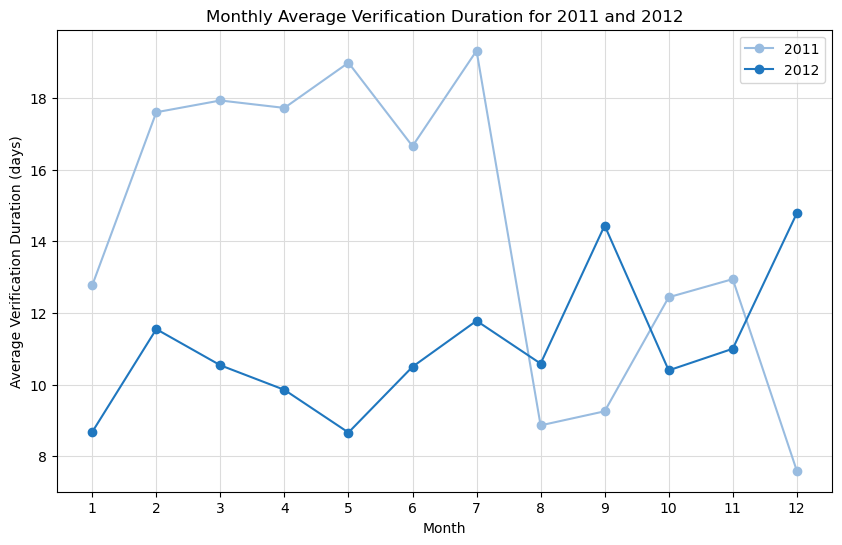

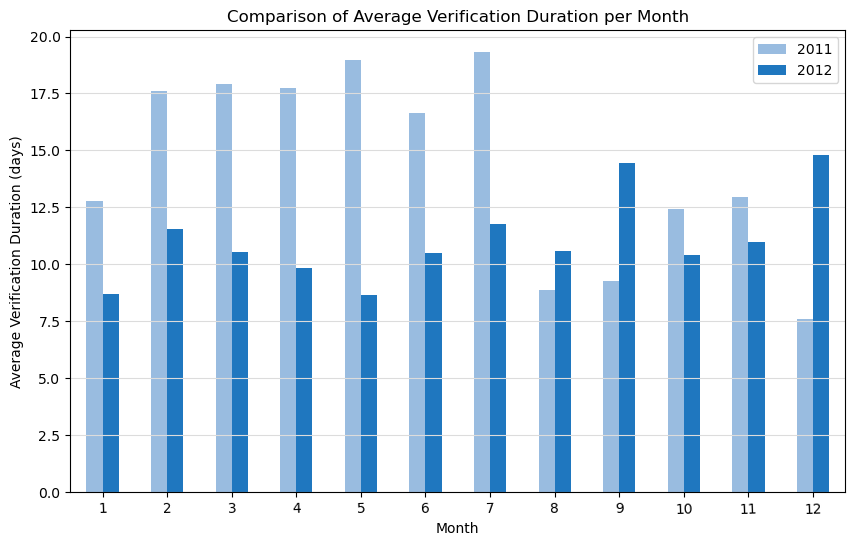

In [30]:
import matplotlib.pyplot as plt

# Convert to datetime
#df['loan_signdate'] = pd.to_datetime(df['loan_signdate'], errors='coerce')
#df['loan_contractapproveddate'] = pd.to_datetime(df['loan_contractapproveddate'], errors='coerce')

# Handle missing and '0000-00-00 00:00:00' values
#df['loan_signdate'].fillna(pd.NaT, inplace=True)
#df['loan_contractapproveddate'].fillna(pd.NaT, inplace=True)
#df['loan_signdate'] = df['loan_signdate'].replace('0000-00-00 00:00:00', pd.NaT)
#df['loan_contractapproveddate'] = df['loan_contractapproveddate'].replace('0000-00-00 00:00:00', pd.NaT)

# Calculate identification verification duration in seconds
df['identification_duration'] = df['loan_contractapproveddate'] - df['loan_signdate']
df['identification_duration'] = df['identification_duration'].dt.total_seconds()

# Handle conditions
df.loc[df['identification_duration'] == 0, 'identification_duration'] = 1  # Replace 0 duration with 1 second
df['identification_duration'] = df['identification_duration'].abs()  # Take the absolute value of negative durations

# Function to convert seconds to days
def convert_seconds_to_days(duration):
    if np.isnan(duration):
        return np.nan
    return duration / (24 * 3600)

# Convert identification duration to days
df['identification_duration_days'] = df['identification_duration'].apply(convert_seconds_to_days)

# Filter data for 2011 and 2012
df_2011 = df[df['loan_signdate'].dt.year == 2011]
df_2012 = df[df['loan_signdate'].dt.year == 2012]

# Calculate monthly average identification duration for 2011
monthly_average_2011 = df_2011.groupby(df_2011['loan_signdate'].dt.month)['identification_duration_days'].mean()

# Calculate monthly average identification duration for 2012
monthly_average_2012 = df_2012.groupby(df_2012['loan_signdate'].dt.month)['identification_duration_days'].mean()

# line plots
plot_data = pd.DataFrame({'Month': range(1, 13),
                          '2011': monthly_average_2011.values,
                          '2012': monthly_average_2012.values})

plot_data.fillna(0, inplace=True)  # Fill NaN values with 0 if any month data is missing

# Line plots
plt.figure(figsize=(10, 6))
plt.plot(plot_data['Month'], plot_data['2011'], color='#99bce0', marker='o', linestyle='-')
plt.plot(plot_data['Month'], plot_data['2012'], color='#1f77bf', marker='o', linestyle='-')
plt.title('Monthly Average Verification Duration for 2011 and 2012')
plt.xlabel('Month')
plt.ylabel('Average Verification Duration (days)')
plt.legend(['2011', '2012'])
plt.xticks(range(1, 13))
plt.grid(color='gainsboro')  
plt.show()

# Bar plots
plot_data.set_index('Month').plot(kind='bar', figsize=(10, 6), color=['#99bce0', '#1f77bf'])
plt.title('Comparison of Average Verification Duration per Month')
plt.xlabel('Month')
plt.ylabel('Average Verification Duration (days)')
plt.xticks(rotation=2)
plt.legend(['2011', '2012'])
plt.grid(axis='y', color='gainsboro')  
plt.show()


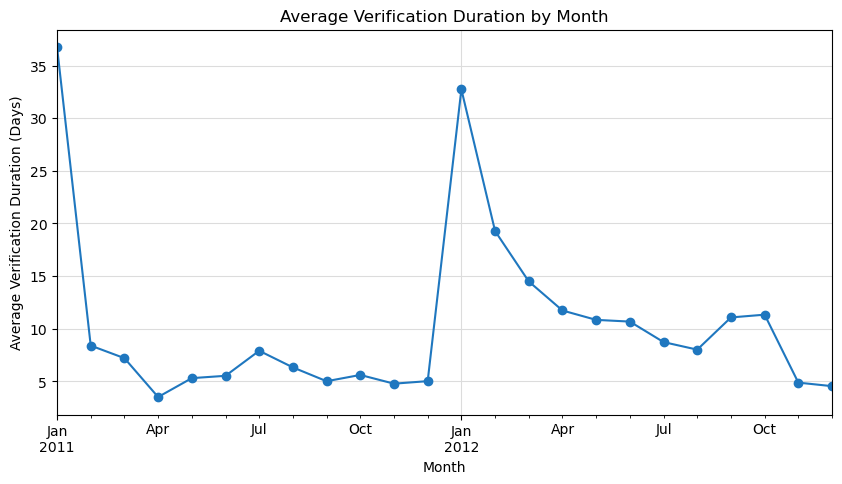

In [31]:
# grid color
grid_color = 'gainsboro'  

# Plot average duration by month
plt.figure(figsize=(10, 5))
average_duration_by_month.plot(marker='o', color='#1f77bf')
plt.xlabel('Month')
plt.ylabel('Average Verification Duration (Days)')
plt.title('Average Verification Duration by Month')
plt.xticks(rotation=0)
plt.grid(True, color=grid_color)
plt.show()


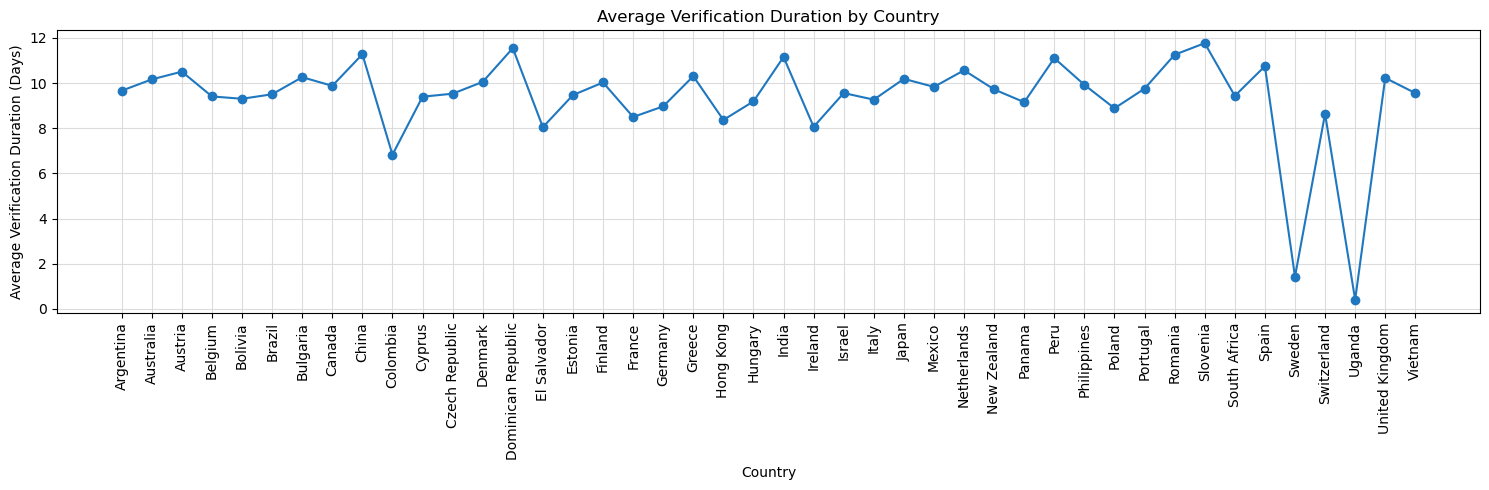

In [32]:
# Sort the average duration by country based on the country names
average_duration_by_country_sorted = average_duration_by_country.reindex(pd.Series(df_cleanse['customer_country'].unique()).sort_values().values)

# Plot average duration by country
plt.figure(figsize=(15, 5))  # Increase the width of the plot
plt.plot(average_duration_by_country_sorted, marker='o', color='#1f77bf')
plt.xlabel('Country')
plt.ylabel('Average Verification Duration (Days)')
plt.title('Average Verification Duration by Country')
plt.xticks(range(len(average_duration_by_country_sorted)), average_duration_by_country_sorted.index, rotation=90) 
plt.grid(True, color=grid_color)
plt.tight_layout() 

plt.show()

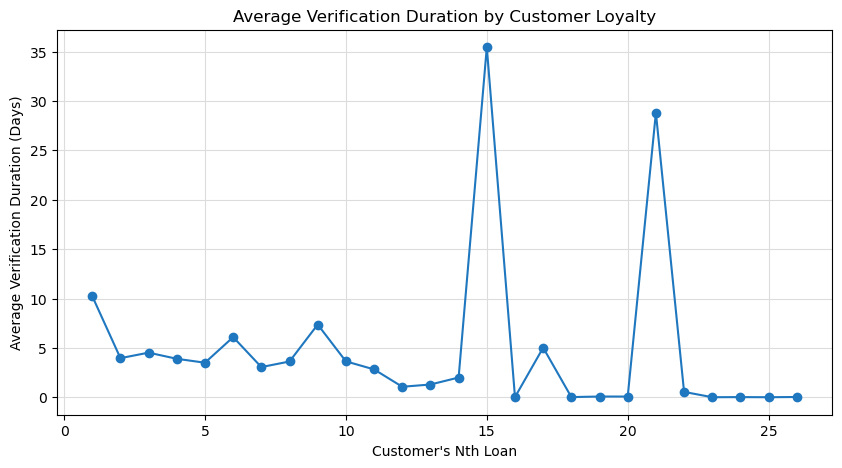

In [33]:
# Plot average duration by customer loyalty
plt.figure(figsize=(10, 5))
average_duration_by_loyalty.plot(marker='o', color='#1f77bf')
plt.xlabel("Customer's Nth Loan")
plt.ylabel('Average Verification Duration (Days)')
plt.title('Average Verification Duration by Customer Loyalty')
plt.xticks(rotation=0)
plt.grid(True, color=grid_color)
plt.show()

In [34]:
# Calculate the metrics
average_verification_time_2011 = df_cleanse[df_cleanse['loan_contractapproveddate'].dt.year == 2011]['verification_duration'].mean()
average_verification_time_2012 = df_cleanse[df_cleanse['loan_contractapproveddate'].dt.year == 2012]['verification_duration'].mean()
improvement = average_verification_time_2011 > average_verification_time_2012
percentage_change = (average_verification_time_2012 - average_verification_time_2011) / average_verification_time_2011 * 100
change_in_days = average_verification_time_2012 - average_verification_time_2011
average_verification_time_by_country_2011 = df_cleanse[df_cleanse['loan_contractapproveddate'].dt.year == 2011].groupby('customer_country')['verification_duration'].mean()
average_verification_time_by_country_2012 = df_cleanse[df_cleanse['loan_contractapproveddate'].dt.year == 2012].groupby('customer_country')['verification_duration'].mean()
slowest_country_2011 = average_verification_time_by_country_2011.idxmax()
fastest_country_2011 = average_verification_time_by_country_2011.idxmin()
slowest_country_2012 = average_verification_time_by_country_2012.idxmax()
fastest_country_2012 = average_verification_time_by_country_2012.idxmin()
improvement_by_country = average_verification_time_by_country_2011 - average_verification_time_by_country_2012
most_improved_country = improvement_by_country.idxmax()
average_verification_time_by_month = df_cleanse.groupby(df_cleanse['loan_contractapproveddate'].dt.to_period('M'))['verification_duration'].mean()
slowest_month = average_verification_time_by_month.idxmax()
fastest_month = average_verification_time_by_month.idxmin()

#average_verification_time_2011, average_verification_time_2012, improvement, percentage_change, change_in_days, slowest_country_2011, fastest_country_2011, slowest_country_2012, fastest_country_2012, most_improved_country, slowest_month, fastest_month
# Display the results
print("Average Verification Time in 2011 (days):", average_verification_time_2011)
print("Average Verification Time in 2012 (days):", average_verification_time_2012)
print("Improvement from 2011 to 2012:", improvement)
print("Percentage Change:", percentage_change)
print("Change in Days:", change_in_days)
print("Slowest Country in 2011:", slowest_country_2011)
print("Fastest Country in 2011:", fastest_country_2011)
print("Slowest Country in 2012:", slowest_country_2012)
print("Fastest Country in 2012:", fastest_country_2012)
print("Most Improved Country:", most_improved_country)
print("Slowest Month:", slowest_month)
print("Fastest Month:", fastest_month)

Average Verification Time in 2011 (days): 8.081012178459032
Average Verification Time in 2012 (days): 11.247313690355282
Improvement from 2011 to 2012: False
Percentage Change: 39.181991586851346
Change in Days: 3.1663015118962505
Slowest Country in 2011: Denmark
Fastest Country in 2011: Uganda
Slowest Country in 2012: Finland
Fastest Country in 2012: Sweden
Most Improved Country: El Salvador
Slowest Month: 2011-01
Fastest Month: 2011-04


### Assumption impact

- I assume that when the approved date column contains null data for approved loans, the contract was signed on the same day as it was approved. This will bring down the average ID verification time. 
- I am assuming that most of the loan status represent an approved loan and therefor count that data in the analysis. If my assumption for these status is wrong then that would impact the results
- I assume that contracts are signed before approval. This might not impact the results too much, as the assumptions would be the same, but perhaps important to mention

# Results
- The average verification time in 2011 was approximately 8.08 days.
- The average verification time in 2012 was approximately 11.24 days.
- There was no improvement from 2011 to 2012. In fact, the verification time increased by about 39%, or approximately 3.16 days.
- The country with the slowest ID verification time in 2011 was Denmark.
- The country with the fastest ID verification time in 2011 was Uganda.
- The country with the slowest ID verification time in 2012 was Finland.
- The country with the fastest ID verification time in 2012 was Sweden.
- The country that improved the most was El Salvador
- The slowest month for ID verification was January 2011.
- The fastest month for ID verification was April 2011.

## Question 2:

Some of LoanCorp’s customers default on their loans before the company is repaid the full
amount of the principal advanced to them. Are there any credit-checking criteria that you
could recommend LoanCorp apply in order to mitigate losses from such bad debts in the
future?

### Executive summary

During data and strategy exploration, I did consider whether I should also take into account ROI for this, but after looking at Question 3 which is focussed on ROI, I decided to answer the question directly without focussing on ROI benefits of higher risk loans to maximise profitability while reducing risk, as I think I can answer that in Question 3. 

#### Monthly Salary and Credit Rating: 
Customers who default tend to have lower average monthly salaries and credit ratings. Therefore, LoanCorp could set minimum thresholds for these variables. For example, they could only approve loans for customers who have a monthly salary above £2800 and a credit rating above 690. This is likely to have a significant impact, as it directly addresses the financial capacity of the customer to repay the loan.

#### Number of Loans: 
Customers who have had more loans with LoanCorp are less likely to default. LoanCorp could give preference to customers who have had more loans with them. For example, they could set a minimum threshold for the number of loans a customer has had, such as 5 loans. This could also have a significant impact, as it takes into account the customer's history with LoanCorp.

#### Age: 
Younger customers are more likely to default on their loans. LoanCorp could apply stricter criteria for younger customers. For example, they could set higher minimum thresholds for the monthly salary and credit rating for customers in the 18-24 and 25-34 age groups. This could have a moderate impact, as age is often correlated with financial stability and responsibility.

#### Loan Principal: 
The default rate decreases as the loan principal increases. LoanCorp could apply stricter criteria for smaller loans. For example, they could set higher minimum thresholds for the monthly salary and credit rating for loans with a principal of £200. This could have a moderate impact, as it addresses the size of the debt burden.

#### Country: 
The default rates vary significantly by country. LoanCorp could apply stricter credit-checking criteria for customers from countries with high default rates. For example, they could set higher minimum thresholds for the monthly salary and credit rating for customers from these countries. This could have a smaller impact, as it's a more indirect factor and could potentially exclude good customers from certain countries.

#### Date of Loan Application: 
The default rate is highest in November. LoanCorp could apply stricter credit-checking criteria for loans that are applied for in November. For example, they could set higher minimum thresholds for the monthly salary and credit rating for these loans. This could have a smaller impact, as it's a more indirect factor and only applies to a specific time of the year.

### Analysis

### Analysis strategy:
- Data preparation: Before working on the 1st question I've already made sure to clean the data. 
- Identify defaulted loans: Identify loans that were defaulted on. I'll do this by looking at the loan status variable
- Analyze characteristics of the defaulted loans: To identify patterns and trends such as customers monthly salary, credit rating, number of previous loans, age, loan principal, and month of loan application
- Compare non-defaulted loans: Characteristics of defaulted loans should be compared with non-defaulted loans to identify differences to help identify factors associated with higher risk of default
- Develop credit checking criteria: Based on results of analytsis, credit checking criteria can be developed to mitigate losses from bad debts. 

1. Read the data.

2. I will use the cleansed data from question 1 as it still applies to this question

3. First of all, I decided I want to look at loan_status, customer_monthly_salary and customer_credit_rating columns as a good starting point as it tell me the customers financial capacity. I expect it to have high impact.

4. I first examine loan_status to understand for each status how many loans were defaulted. For the purpose of this analysis I consider SUSPENDED, BANK ACCOUNT CLOSED, BANKRUPTCY CONFIRMED, and COLLECTIONS statuses as defaults.

In [35]:
# Add the definition of defaulted loans
defaulted_loans = df_cleanse[df_cleanse['loan_status'].isin(['SUSPENDED', 'BANK ACCOUNT CLOSED', 'BANKRUPTCY CONFIRMED', 'COLLECTIONS'])]

# Analyze characteristics of defaulted loans
defaulted_loans_describe = defaulted_loans.describe(include='all', datetime_is_numeric=True)

# Compare with non-defaulted loans
non_defaulted_loans = df_cleanse[~df_cleanse['loan_status'].isin(['SUSPENDED', 'BANK ACCOUNT CLOSED', 'BANKRUPTCY CONFIRMED', 'COLLECTIONS'])]
non_defaulted_loans_describe = non_defaulted_loans.describe(include='all', datetime_is_numeric=True)

defaulted_loans_describe


,customer_id,customer's_nth_loan,loan_signdate,loan_contractapproveddate,loan_principal,loan_status,customer_country,customer_date_of_birth,customer_monthly_salary,customer_credit_rating,total_collected,verification_duration,region
count,1.593680e+05,159368.000000,159366,159368,159368.000000,159368,159368,159367,159368.000000,159368.000000,159368.000000,159366.000000,159368
unique,NaN,NaN,NaN,NaN,NaN,4,44,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,SUSPENDED,Canada,NaN,NaN,NaN,NaN,NaN,Europe
freq,NaN,NaN,NaN,NaN,NaN,83274,18695,NaN,NaN,NaN,NaN,NaN,70232
mean,1.721145e+06,1.055168,2012-01-29 23:15:46.594631168,2012-01-31 00:57:05.220747008,201.339980,NaN,NaN,1975-07-19 18:26:45.697540928,2481.156877,672.252397,275.357666,10.076392,NaN
min,2.678000e+03,1.000000,2011-01-01 11:59:00,2011-01-01 11:59:00,200.000000,NaN,NaN,1940-11-02 00:00:00,250.000000,450.000000,0.000000,0.000000,NaN
25%,1.240938e+06,1.000000,2011-08-08 12:24:30,2011-08-08 16:24:30,200.000000,NaN,NaN,1968-12-24 00:00:00,1625.000000,630.000000,0.000000,0.009722,NaN
50%,1.622422e+06,1.000000,2012-01-20 19:00:00,2012-01-23 18:59:00,200.000000,NaN,NaN,1976-11-03 00:00:00,2200.000000,680.000000,79.000000,0.096528,NaN
75%,2.186362e+06,1.000000,2012-08-06 18:09:45,2012-08-09 11:06:15,200.000000,NaN,NaN,1983-03-31 00:00:00,3000.000000,720.000000,316.000000,0.847917,NaN
max,3.075510e+06,14.000000,2012-12-31 15:48:00,2012-12-31 17:29:00,300.000000,NaN,NaN,1999-11-30 00:00:00,5780.000000,890.000000,6490.000000,340.895139,NaN


In [36]:
non_defaulted_loans_describe

,customer_id,customer's_nth_loan,loan_signdate,loan_contractapproveddate,loan_principal,loan_status,customer_country,customer_date_of_birth,customer_monthly_salary,customer_credit_rating,total_collected,verification_duration,region
count,3.920600e+04,39206.000000,39201,39206,39206.000000,39206,39206,39206,39206.000000,39206.000000,39206.000000,39201.000000,39206
unique,NaN,NaN,NaN,NaN,NaN,4,44,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,PAID IN FULL,Canada,NaN,NaN,NaN,NaN,NaN,Europe
freq,NaN,NaN,NaN,NaN,NaN,36286,4828,NaN,NaN,NaN,NaN,NaN,17668
mean,1.482094e+06,1.613452,2012-01-13 09:33:22.880538880,2012-01-14 12:02:45.925113600,207.327960,NaN,NaN,1974-01-21 12:02:05.613426512,2683.943667,689.532470,801.118363,8.319425,NaN
min,2.751000e+03,1.000000,2011-01-01 12:12:00,2011-01-01 16:13:00,200.000000,NaN,NaN,1940-03-01 00:00:00,250.000000,400.000000,0.000000,0.000000,NaN
25%,1.026413e+06,1.000000,2011-07-23 19:49:00,2011-07-24 14:21:00,200.000000,NaN,NaN,1967-01-31 00:00:00,1751.000000,650.000000,358.000000,0.006944,NaN
50%,1.427882e+06,1.000000,2012-01-02 18:56:00,2012-01-04 16:03:00,200.000000,NaN,NaN,1975-02-08 12:00:00,2498.000000,690.000000,516.000000,0.068750,NaN
75%,1.850162e+06,2.000000,2012-07-13 10:10:00,2012-07-16 12:50:45,200.000000,NaN,NaN,1981-12-23 18:00:00,3400.000000,740.000000,911.000000,0.654861,NaN
max,3.074974e+06,26.000000,2012-12-31 15:35:00,2012-12-31 15:58:00,300.000000,NaN,NaN,1999-11-30 00:00:00,5777.000000,890.000000,6655.000000,334.012500,NaN


In [37]:
# Count of defaulted loans for each loan_status category
defaulted_loans['loan_status'].value_counts()

SUSPENDED               83274
BANK ACCOUNT CLOSED     75694
BANKRUPTCY CONFIRMED      223
COLLECTIONS               177
Name: loan_status, dtype: int64

5. Then I analysed the characteristics of the customers who default on their loans. First i will compare the customer_monthly_salary and customer_credit_rating for defaulted / non-defaulted loans

The average monthly salary for credit ratings for customers who default and those who don't are:
- Customers who don't default:

    - Average monthly salary: ~£2683
    - Average credit rating: ~689
- Customers who default:

    - Average monthly salary: ~£2481
    - Average credit rating: ~672

6. Then as different countries could have different enconomic conditions, culture towards debt and laws for debt collection, I decided I should analyse the default rates by country. 

This calculates the proportion of loans that were defaulted in each country. This will give me an idea of which countries have higher / lower default rates. 

In [38]:
# Create a new column 'defaulted' that indicates whether the loan was defaulted
df_cleanse['defaulted'] = df_cleanse['loan_status'].isin(['SUSPENDED', 'BANK ACCOUNT CLOSED', 'BANKRUPTCY CONFIRMED', 'COLLECTIONS'])

# Calculate the default rates by country
default_rates_by_country = df_cleanse.groupby('customer_country')['defaulted'].mean().sort_values(ascending=False)
default_rates_by_country

customer_country
Slovenia              0.892308
India                 0.863524
Panama                0.856043
Dominican Republic    0.855517
Greece                0.854191
Japan                 0.847407
Switzerland           0.847196
South Africa          0.845503
China                 0.844720
Romania               0.839816
Netherlands           0.839006
Austria               0.837658
Mexico                0.835126
Argentina             0.834825
Denmark               0.832714
Hong Kong             0.832645
Finland               0.830051
Cyprus                0.822408
United Kingdom        0.821759
Bulgaria              0.810644
Brazil                0.803910
Portugal              0.798600
Canada                0.794754
Philippines           0.791671
Estonia               0.791100
Australia             0.787415
Czech Republic        0.786501
El Salvador           0.786408
Poland                0.783100
Peru                  0.780975
Germany               0.774074
Belgium               

I can see from this data that default rates change a lot by country. Slovenia, India, Panama and Dominican Republic have high default rates. While Sweden has lower default rates.

This data show me that LoanCorp could mitigate losses by applying stricter criteria for customers from countries with high default rates.

7. I wanted to see if the number of loans (i.e. Customer Loyalty) would also have an impact on reliabilitry, as I think that if they have a history of repaying their loans, they should be more reliable. 

I analyzed the default rates by the number of loans a customer has had. This calculates the proportion of loans that were defaulted for each number of loans a customer had. This shows me whether customers with more loans are more reliable.

In [39]:
# Calculate the default rates by the number of loans a customer has had
default_rates_by_loan_number = df_cleanse.groupby("customer's_nth_loan")['defaulted'].mean().sort_values(ascending=False)
default_rates_by_loan_number

customer's_nth_loan
1     0.842028
2     0.463324
3     0.296213
4     0.207687
5     0.184690
6     0.141053
9     0.118644
8     0.107692
7     0.099656
10    0.096386
11    0.074074
14    0.062500
12    0.032258
13    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
Name: defaulted, dtype: float64

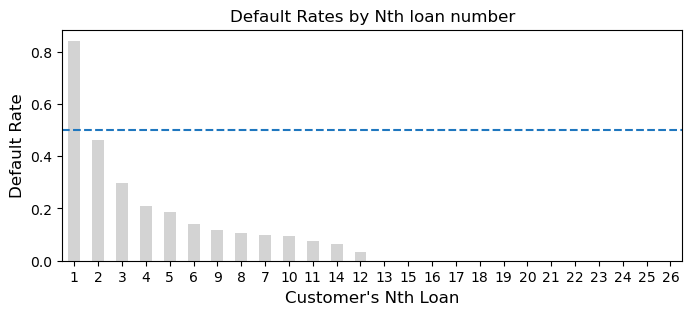

In [40]:
#import matplotlib.pyplot as plt

# Calculate the default rates by the number of loans a customer has had
default_rates_by_loan_number = df_cleanse.groupby("customer's_nth_loan")['defaulted'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(8, 3))
default_rates_by_loan_number.plot(kind='bar', color='lightgrey')#'#1f77bf'

# labels and title
plt.xlabel("Customer's Nth Loan", fontsize=12)
plt.ylabel('Default Rate', fontsize=12)
plt.title('Default Rates by Nth loan number', fontsize=12)

# Rotate
plt.xticks(rotation=0)

# y-axis 0.5
plt.axhline(y=0.5, color='#1f77bf', linestyle='--')

# Add outlier marker
#plt.plot([-0.5, len(default_rates_by_loan_number) - 0.5], [1, 1], color='red', linestyle='--')

plt.show()

I can see that the default rate decreases as the number of loans a customer has had increases. This tells me that customers who have had more loans with LoanCorp are less likely to default

LoanCorp could apply to mitigate losses from bad debts by giving preference to customers who have had more loans with LoanCorp. For example, they could increase the salary / credit rating threshold if customers are applying for their first loan, and reduce the threshold as they apply for more loans.

8. I wasn't sure if date would be a valid criteria to mitigate bad debt, but my assumption was people who apply for loans during Christmas may try to borrow more than they can afford. So I wanted to check if there is a seasonable pattern.

The below code analyses the default rate by month, shown as a proportion of loans that were defaulted for each month of the year. 

In [41]:
# Create a new column for the month of the loan sign date
df_cleanse['loan_month'] = df_cleanse['loan_signdate'].dt.month

# Create a new column for the quarter of the loan sign date
df_cleanse['loan_quarter'] = df_cleanse['loan_signdate'].dt.to_period('Q')


# Calculate the default rate by month
default_rate_by_month = df_cleanse.groupby('loan_month')['defaulted'].mean()
default_rate_by_month

loan_month
1.0     0.749733
2.0     0.785859
3.0     0.800475
4.0     0.806359
5.0     0.806568
6.0     0.799124
7.0     0.805747
8.0     0.806137
9.0     0.803934
10.0    0.809950
11.0    0.830419
12.0    0.805402
Name: defaulted, dtype: float64

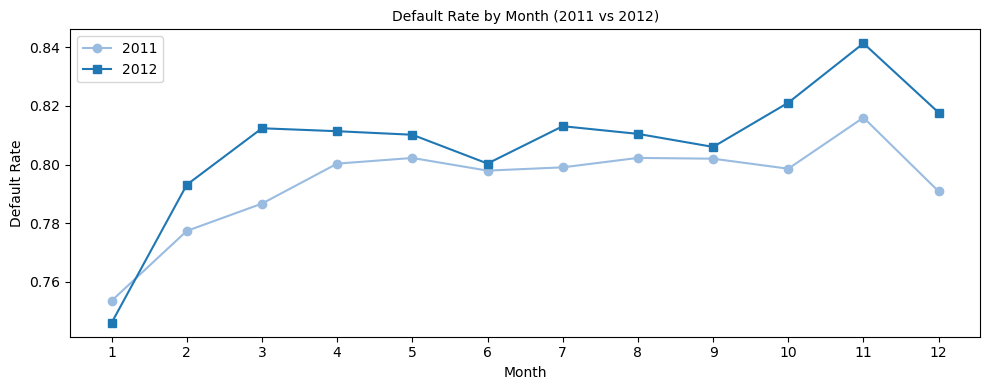

In [42]:
#import matplotlib.pyplot as plt

# Filter the dataframe for the years 2011 and 2012
df_2011 = df_cleanse[df_cleanse['loan_contractapproveddate'].dt.year == 2011]
df_2012 = df_cleanse[df_cleanse['loan_contractapproveddate'].dt.year == 2012]

# Calculate the default rate by month for each year
default_rate_2011 = df_2011.groupby('loan_month')['defaulted'].mean()
default_rate_2012 = df_2012.groupby('loan_month')['defaulted'].mean()

# line plot for 2011
plt.figure(figsize=(10, 4))
default_rate_2011.plot(kind='line', color='#99bce0', marker='o', label='2011')#'#99bce0'

# line plot for 2012
default_rate_2012.plot(kind='line', color='#1f77b4', marker='s', label='2012')#'#1f77b4'

# labels and title
plt.xlabel('Month', fontsize=10)
plt.ylabel('Default Rate', fontsize=10)
plt.title('Default Rate by Month (2011 vs 2012)', fontsize=10)

plt.xticks(range(1, 13))  # Assuming the data spans all 12 months
plt.legend()
plt.tight_layout()
plt.show()

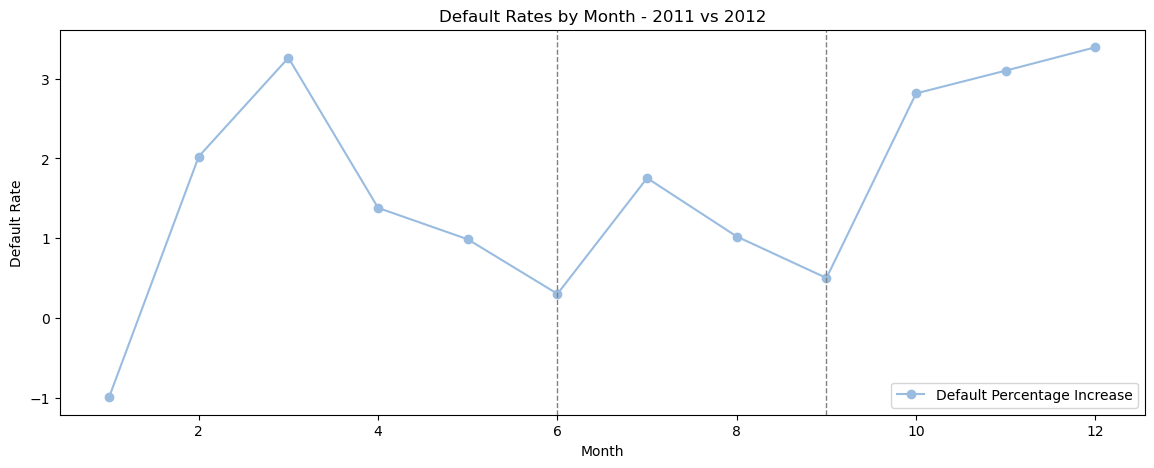

In [43]:
import matplotlib.pyplot as plt

# Calculate the default rate by month for each year
default_rate_2011 = df_2011.groupby('loan_month')['defaulted'].mean()
default_rate_2012 = df_2012.groupby('loan_month')['defaulted'].mean()

# Calculate the percentage increase in the default rate for each month
percentage_increase = ((default_rate_2012 - default_rate_2011) / default_rate_2011) * 100

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 5))

# Plot the default rate by month for 2011
#ax.plot(default_rate_2011.index, default_rate_2011, marker='o', color='#99bce0', label='2011')

# Plot the default rate by month for 2012
#ax.plot(default_rate_2012.index, default_rate_2012, marker='o', color='#1f77b4', label='2012')

# Set the labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Default Rate')
ax.set_title('Default Rates by Month - 2011 vs 2012')

# Plot the percentage increase line
ax.plot(percentage_increase.index, percentage_increase, marker='o', color='#99bce0', label='Default Percentage Increase')

# vertical grid 
ax.axvline(x=6, color='grey', linestyle='--', linewidth=1)
ax.axvline(x=9, color='grey', linestyle='--', linewidth=1)

ax.legend()
plt.show()


I can see the highest default rate is November, as expected, perhaps due to customers borrowing more than they can afford due to the holiday season.

LoanCorp could apply stricter criteria for Loans that are applied for in November.

10. Below I decide to analyse based on age group to see if age impacts financial behaviour and capabilities. This calculates the proportion of loans that defaulted for each age group.

Calculate the age of each customer at the time of loan application, then group the customers into age groups.

In [44]:
# Calculate the age of the customer at the time of the loan
df_cleanse['age_at_loan'] = (df_cleanse['loan_signdate'] - df_cleanse['customer_date_of_birth']).dt.days // 365

# Calculate the default rate by age
default_rate_by_age = df_cleanse.groupby('age_at_loan')['defaulted'].mean()
default_rate_by_age

age_at_loan
11.0    0.500000
19.0    1.000000
20.0    0.882353
21.0    0.867728
22.0    0.859193
23.0    0.848449
24.0    0.838678
25.0    0.825799
26.0    0.833079
27.0    0.821768
28.0    0.818217
29.0    0.809053
30.0    0.809069
31.0    0.821270
32.0    0.809153
33.0    0.804281
34.0    0.800435
35.0    0.797888
36.0    0.805763
37.0    0.804003
38.0    0.797389
39.0    0.786364
40.0    0.803770
41.0    0.797852
42.0    0.795926
43.0    0.793499
44.0    0.767895
45.0    0.782858
46.0    0.795080
47.0    0.777884
48.0    0.790349
49.0    0.776811
50.0    0.787189
51.0    0.769557
52.0    0.751801
53.0    0.752888
54.0    0.779693
55.0    0.757675
56.0    0.740185
57.0    0.728985
58.0    0.727492
59.0    0.703196
60.0    0.745530
61.0    0.438356
62.0    0.200000
63.0    0.833333
64.0    0.333333
65.0    1.000000
66.0    1.000000
67.0    1.000000
68.0    1.000000
70.0    0.000000
71.0    0.750000
Name: defaulted, dtype: float64

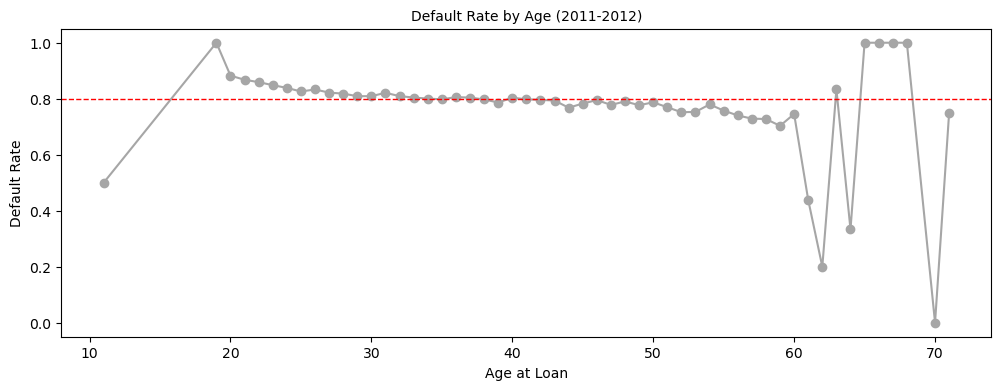

In [45]:
#import matplotlib.pyplot as plt

# Calculate the default rate by age
default_rate_by_age = df_cleanse.groupby('age_at_loan')['defaulted'].mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the default rate by age
ax.plot(default_rate_by_age.index, default_rate_by_age, marker='o', color='#a6a6a6')#'#99bce0', '#a6a6a6'

# Add a horizontal line at y-axis value 0.8
ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1)

# Set the labels and title
ax.set_xlabel('Age at Loan',fontsize=10)
ax.set_ylabel('Default Rate',fontsize=10)
ax.set_title('Default Rate by Age (2011-2012)',fontsize=10)

plt.show()



In [46]:
# Define age groups
bins = [18, 24, 34, 44, 54, 64, np.inf]
names = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Create a new column for age groups
df_cleanse['age_group'] = pd.cut(df_cleanse['age_at_loan'], bins, labels=names)

# Calculate the default rate by age group
default_rate_by_age_group = df_cleanse.groupby('age_group')['defaulted'].mean()
default_rate_by_age_group

age_group
18-24    0.848279
25-34    0.815291
35-44    0.795889
45-54    0.778391
55-64    0.731903
65+      0.812500
Name: defaulted, dtype: float64

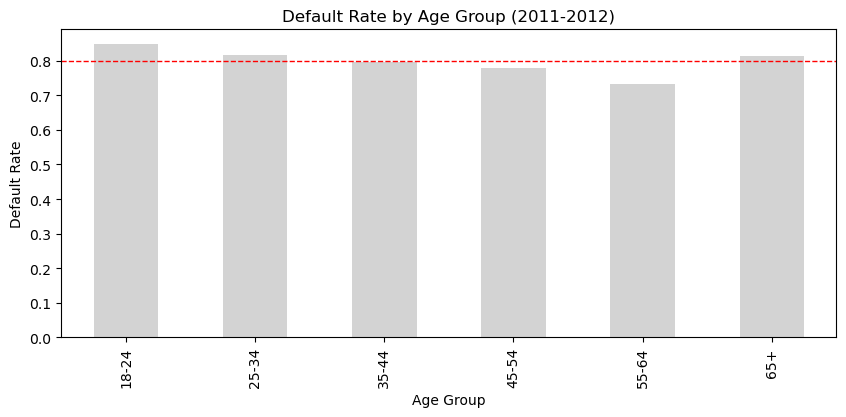

In [47]:
#import matplotlib.pyplot as plt

# Calculate the default rate by age group
default_rate_by_age_group = df_cleanse.groupby('age_group')['defaulted'].mean()

# Create a bar plot
plt.figure(figsize=(10, 4))
default_rate_by_age_group.plot(kind='bar', color='lightgrey') #'#a6a6a6'

# Add a horizontal line at y-axis value 0.8
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1)

# Set the labels and title
plt.xlabel('Age Group')
plt.ylabel('Default Rate')
plt.title('Default Rate by Age Group (2011-2012)')

# Display the plot
plt.show()


I can see that the default rate decreases as the age of the customer increases, until you get to 65+ where the default rate increases significantly.  This suggests younger customers and retired customers are more likely to default on their loans.

LoanCorp could apply stricter criteria for younger and retired customers. For example, they could set higher minimum thresholds for the monthly salary and credit rating for customers in the 18-24 and 25-34 age groups and 65+ age groups.

Lastly, I wanted to check if the amount a customer borrows impacts default rate. I analyzed the default rates by loan principal. 

In [48]:
# Calculate the default rate by loan principal
default_rate_by_loan_principal = df_cleanse.groupby('loan_principal')['defaulted'].mean()
default_rate_by_loan_principal

loan_principal
200    0.814367
250    0.436646
300    0.423613
Name: defaulted, dtype: float64

This was unexpected. The smaller amount customers borrow, the more likely they are to default. Perhaps a reason for this is LoanCorp already have stricter criteria the more you borrow.

As it seems LoanCorp might already be doing this, it seems suggesting this would be low impact, but if not, LoanCorp could apply stricter criteria for smaller loans.

### Assumption impact
- By cleansing the salary and credit rating data based on the assumptions made above, it may have impacted the salary and credit rating thresholds.

### Results

- The average monthly salary for customers who don't default is ~£2683, and their credit rating is ~689
- The average monthjly salary for customers who do default is ~£2481, and their credit rating is ~672
- This suggests LoanCorp could apply this strict criteria to their customers to mitigate bad debt. 
- Also, based on analysis it would be beneficial for LoanCorp to apply this stricter salary / credit rating criteria to the following:

    - Monthly Salary and Credit Rating (Just apply criteria based on salary / credit rating in general)
    - Number of loans (Newer customers should have stricter criteria)
    - Age (Younger customers should have stricter criteria)
    - Loan Principal (Customers borrowing larger amounts should have stricter criteria, but this might already be applied)
    - Country (I saw a significant difference in default rates by country, but difficult to directly correlate country to default rate as it might be out of the customers control)
    - Date of loan application (Smaller impact, but applying stricter criteria in November would mitigate bad debt)

## Question 3:

Suppose another company, QuidCo, is a start-up in the loan market. QuidCo are given
LoanCorp’s historical loan data to help set their own funding policy.
As an analyst for QuidCo, devise a simple and practical strategy with the data provided in
order to maximise QuidCo’s profit using the assumption that QuidCo could only have funded
at most 50% of LoanCorp’s loan book in any given period.

### Executive summary

My strategy involves two main components: 
- Minimizing the risk of default
- maximizing the return on each loan.

To minimize the risk of default, QuidCo should apply the credit checking criteria derived from LoanCorp's data. This includes considering factors such as the customer's monthly salary, credit rating, number of previous loans, age, loan principal, and the month of loan application. For example, customers with higher monthly salaries and credit ratings, fewer previous loans, and who apply for loans outside of the peak default months (November and December) are less likely to default on their loans.

Please see results from Question 2 for more information on why I picked these criteria.

To maximize the return on each loan, QuidCo should prioritize loans with higher principals and customers who have a history of repaying their loans in full. The data shows that customers who have had multiple loans with LoanCorp are more likely to repay their loans in full, suggesting that customer loyalty is a strong indicator of loan repayment.

However, QuidCo should also consider the constraint that it can only fund at most 50% of LoanCorp’s loan book in any given period. This means that QuidCo should prioritize the most profitable and least risky loans within this limit.

### Analysis

### Analysis strategy:
- Data preparation: Before working on the 1st question I've already made sure to clean the data. 
- Risk minimization: Device a strategy for minimising risk. Luckily I already have a strategy from question 2.
- Return maximization: Prioritize loans with higher principals and customers who have a history of repaying their loans in full to maximise returns
- Funding constraint: Considering QuidCo can only fund at most 50% of LoanCorp's loan book in any given period, Quidco should prioritise the most profitable and least risky loans within its limit. 

1. Read the data

2. I will use the cleansed data from question 1 as it still applies to this question

3. I started by identifying loans that were most profitable for LoanCorp. These are loans that were repaid in full, with the highest difference between the total amount collected and the loan principal. I'll then select the top 50% of these loans by principal, as these are the only loans QuidCo could have funded. 

The total return from these loans will give me an estimate of the potential profit for QuidCo. 

For now i'm not doing any risk mitigation.

In [49]:
# Filter the data to only include loans that were repaid in full
repaid_loans = df_cleanse[df_cleanse['loan_status'] == 'PAID IN FULL'].copy()

# Calculate the total return for each loan
repaid_loans['total_return'] = repaid_loans['total_collected'] - repaid_loans['loan_principal']

# Sort the loans by total return in descending order
sorted_loans = repaid_loans.sort_values('total_return', ascending=False)

# Calculate the cumulative sum of the loan principals
sorted_loans['cumulative_principal'] = sorted_loans['loan_principal'].cumsum()

# Calculate the total loan principal
total_principal = sorted_loans['loan_principal'].sum()

# Filter the loans to only include the top 50% by principal
top_loans = sorted_loans[sorted_loans['cumulative_principal'] <= total_principal * 0.5]

# Calculate the total return from the top loans
total_return = top_loans['total_return'].sum()

print("Total Return: £", total_return)

Total Return: £ 15733541.7700001


Without considering any risk factors, I can see the total return would be £15,733,541.

Now let's mimimise risk of default. As I've seen with previous analysis in Question 2, there are several factors that can help predict whether a customer is likely to repay their loan in full. 

#### Specifically:
- Higher minimum thresholds for monthly salary and credit rating. Especially for first time borrowers and loans applied for in November.
- I would recommend considering customers age. Younger customers are more likely to default.
- Loan principal is also key, as larger loans are more likely to be defaulted on, so QuidCo might weant to set a maximum principal they're willing to lend, or require additional checks / guarantees for larger loans
- Analysis shows that customers from certain countries are more likely to default on their loans. So Quidco could either avoid certain countries, or put different thresholds on those countries.

#### Maximising the return for each loan:
- Quidco should prioritise loans with higher principals, even though they're higher risk they have a higher total return.
- Prioritise customers who have a history of repaying loans in full. They're more likely to be reliable and profitable in the future
- Only fund the top 50% of the most profitable loans. This will involve making compromises between risk and return.

4. Apply the same risk minimising criteria from question 2 to get the top 50% of loans by principal.

In [50]:
# Convert the 'customer_date_of_birth' column to datetime format, coercing errors
df_cleanse['customer_date_of_birth'] = pd.to_datetime(df_cleanse['customer_date_of_birth'], errors='coerce')

# Calculate the age of the customer at the time of the loan
df_cleanse['customer_age'] = (df_cleanse['loan_signdate'] - df_cleanse['customer_date_of_birth']).dt.days // 365

# Filter the data to only include loans that meet the risk-minimizing criteria. I've made is slightly more relaxed
# than the criteria in question 2 to be able to balance risk with maximising return
low_risk_loans = df_cleanse[
    (df_cleanse['customer_monthly_salary'] >= 2800) & #  Slightly higher than the average salary of a customer who doesn't default
    (df_cleanse['customer_credit_rating'] >= 690) & # About the same credit rating of a customer who doesn't default
    (df_cleanse['customer\'s_nth_loan'] > 1) & # Focus on customers that I know repay their debts
    (df_cleanse['customer_age'] >= 25) & # Target users older than 25. I didn't include retired here
    (df_cleanse['loan_principal'] >= 200) # I wont filter by loan_principal
    #(~df_cleanse['loan_signdate'].dt.month.isin([11, 12])) # I was going to filter by month, but I think that's narrowing it too much
].copy()  # Create a copy of the DataFrame slice


# Calculate the total return for each loan
low_risk_loans.loc[:, 'total_return'] = low_risk_loans['total_collected'] - low_risk_loans['loan_principal']

# Sort the loans by total return in descending order
sorted_loans = low_risk_loans.sort_values('total_return', ascending=False)

# Calculate the cumulative sum of the loan principals
sorted_loans['cumulative_principal'] = sorted_loans['loan_principal'].cumsum()

# Calculate the total loan principal
total_principal = sorted_loans['loan_principal'].sum()

# Filter the loans to only include the top 50% by principal
top_loans = sorted_loans[sorted_loans['cumulative_principal'] <= total_principal * 0.5]

# Calculate the total return from the top loans
total_return = top_loans['total_return'].sum()

print("Total Return: £", total_return)

Total Return: £ 1385905.0499999998


Total return if I consider risk while trying to maximise return: £1,385,905

### Assumption impact
- If salary, loan status, credit rating assumptions are wrong, this could impact the data
- The question asks to device a strategy to maximise QuidCo's profit, but it doesn't mention minimising risk in this case. There's a lot of profit left on the table by managing risk, but this may be acceptable to QuidCo.

### Results

- Based on risk mitigation strategies from Question 2, and by priortising loans with higher principals, and customers who have a history of repaying their loans, Quidcos total return would be approximately  £1,385,905. This is a good balance between risk and profit.
- If Quidco are only interested in the most profit without considering risk for now, they would make a total return of approximately £15,733,541 assuming they only fund the top 50% of LoanCorps most profitable loans.

In summary I believe Quidcos strategy should be to minimize risk by applying the credit / salary checking criteria mentioned above, and maximise return for each loan by prioritising loans with higher principals and customers who have a history of repaying their loans.

## Question 4

LoanCorp’s marketing department suggested the implementation of SMS campaigns
targeting previous customers of LoanCorp who had at least one loan in the past and had
paid that loan in full. The messages informed the customers, which you can see in File2.xlsx,
that they were able to apply for a new loan.
Evaluate the success of the campaigns. Assume a cost of £0.10 per SMS.

### Executive summary

The analysis of the campaign data showed that the SMS campaigns were highly successful. The return on investment (ROI) for the campaigns was significantly positive, indicating that the campaigns generated a substantial increase in loan principal relative to the cost of the SMS messages.

The success of the campaigns varied depending on different factors such as the customer's country, age, credit rating, and monthly salary. For example, the campaigns were particularly successful in countries like Sweden, Hong Kong and Romania, among customers aged 40-59, with credit ratings above 500. 

The campaigns were also more successful during certain periods of the year. The ROI was towards the end of the year, although this may be related to seasonal trends such as holidays.

Furthermore, the campaigns appeared to have a positive impact on customer loyalty. Customers who received an SMS and had more than one loan contributed significantly to the total loan principal, indicating that the campaigns were effective in promoting repeat business.

In conclusion, the SMS campaigns were a cost-effective strategy for increasing loan principal and promoting customer loyalty. However, the success of the campaigns varied depending on different factors, suggesting that more targeted campaigns could potentially yield even higher returns.

### Analysis

### Analysis strategy:
- Data preparation: Before working on the 1st question I've already made sure to clean the data. I've also made sure to include information about the customers, loans and SMS campaigns here.
- Calculate ROI: Calculate ROI for the SMS campaigns. I can do this by subtracting the cost of SMS messages from the increase in loan principal attributed to the campaigns. Then I can dividing by the cost of the SMS messages. I will express it as a % to make it easier to interpret
- Analyze ROI by different factors: I will analyze by country, age, credit rating, monthly salary and the month of the SMS campaign. This will identify which factors are associated with higher ROI
- Analyze impact on customer loyalty: The impact of SMS campaigns on customer loyalty can be analyzed by looking at the number of loans taken out by customers who received an SMS. This will help determine if the campaign was effective to promote repeat business.

1. Read the data

2. Use the clean dataframe for the first file (df.cleanse)

3. Use the clean dataframe from the second file (df1.cleanse)

4. I will link the SMS data with the loan data using the customer IDs

In [51]:
# Merge the loan data with the SMS data. When I inspected the data I found some rows in the sms data that had a sms_cust_id that didn't correspond with a customer_id in the loan data. I've already cleansed it and that data is in df1_cleanse already. So no need to do an outer join here.
df_cleansed_merged = pd.merge(df_cleanse, df1_cleanse, left_on='customer_id', right_on='sms_cust_id', how='inner')

df_cleansed_merged.head()

,customer_id,customer's_nth_loan,loan_signdate,loan_contractapproveddate,loan_principal,loan_status,customer_country,customer_date_of_birth,customer_monthly_salary,customer_credit_rating,...,region,defaulted,loan_month,loan_quarter,age_at_loan,age_group,customer_age,sms_id,sms_cust_id,sms_sent
0,466586,1,2011-02-01 01:53:00,2011-02-01 01:53:00,200,PAID IN FULL,France,1973-12-31,2882.0,680.0,...,Europe,False,2.0,2011Q1,37.0,35-44,37.0,48757,466586.0,05/09/2012 18:05
1,466586,1,2011-02-01 01:53:00,2011-02-01 01:53:00,200,PAID IN FULL,France,1973-12-31,2882.0,680.0,...,Europe,False,2.0,2011Q1,37.0,35-44,37.0,48759,466586.0,05/09/2012 16:07
2,466586,1,2011-02-01 01:53:00,2011-02-01 01:53:00,200,PAID IN FULL,France,1973-12-31,2882.0,680.0,...,Europe,False,2.0,2011Q1,37.0,35-44,37.0,62173,466586.0,13/09/2012 14:59
3,466586,1,2011-02-01 01:53:00,2011-02-01 01:53:00,200,PAID IN FULL,France,1973-12-31,2882.0,680.0,...,Europe,False,2.0,2011Q1,37.0,35-44,37.0,74749,466586.0,19/09/2012 17:37
4,466586,1,2011-02-01 01:53:00,2011-02-01 01:53:00,200,PAID IN FULL,France,1973-12-31,2882.0,680.0,...,Europe,False,2.0,2011Q1,37.0,35-44,37.0,86623,466586.0,27/09/2012 11:59


In [52]:
# Create a column indicating whether the loan was signed after the SMS was sent
df_cleansed_merged['post_sms'] = df_cleansed_merged['loan_signdate'] > df_cleansed_merged['sms_sent']

# Calculate the total loan principal and the number of loans before and after the SMS campaigns
pre_sms_principal = df_cleansed_merged.loc[~df_cleansed_merged['post_sms'], 'loan_principal'].sum()
post_sms_principal = df_cleansed_merged.loc[df_cleansed_merged['post_sms'], 'loan_principal'].sum()
pre_sms_loans = df_cleansed_merged.loc[~df_cleansed_merged['post_sms'], 'loan_principal'].count()
post_sms_loans = df_cleansed_merged.loc[df_cleansed_merged['post_sms'], 'loan_principal'].count()

# Calculate the cost of the SMS campaigns
sms_cost = df1_cleanse['sms_id'].count() * 0.10

# Calculate the return on investment (ROI) for the SMS campaigns
roi = (post_sms_principal - pre_sms_principal - sms_cost) / sms_cost

# Display the results
pre_sms_principal, post_sms_principal, pre_sms_loans, post_sms_loans, sms_cost, roi

print("Total Principal before SMS campaigns: £", pre_sms_principal)
print("Total Principal after SMS campaigns: £", post_sms_principal)
print("Number of Loans before SMS campaigns: £", pre_sms_loans)
print("Number of Loans after SMS campaigns: £", post_sms_loans)
print("SMS Campaign Cost: £", sms_cost)
print("Return on Investment (ROI) for SMS campaigns: £", roi)

Total Principal before SMS campaigns: £ 12092350
Total Principal after SMS campaigns: £ 3212650
Number of Loans before SMS campaigns: £ 58576
Number of Loans after SMS campaigns: £ 13703
SMS Campaign Cost: £ 5313.0
Return on Investment (ROI) for SMS campaigns: £ -1672.3156408808584


In [53]:
# Filter the SMS data to only include messages with a customer ID (Noticed I already did this in the data cleanse, but no harm to keep it. For testing)
df_sms_with_id = df1_cleanse.dropna(subset=['sms_cust_id'])

# Merge the loan data with the filtered SMS data
df_merged_with_id = pd.merge(df_cleanse, df_sms_with_id, left_on='customer_id', right_on='sms_cust_id', how='inner')

# Create a column indicating whether the loan was signed after the SMS was sent
df_merged_with_id['post_sms'] = df_merged_with_id['loan_signdate'] > df_merged_with_id['sms_sent']

# Calculate the total loan principal and the number of loans before and after the SMS campaigns
pre_sms_principal_with_id = df_merged_with_id.loc[~df_merged_with_id['post_sms'], 'loan_principal'].sum()
post_sms_principal_with_id = df_merged_with_id.loc[df_merged_with_id['post_sms'], 'loan_principal'].sum()
pre_sms_loans_with_id = df_merged_with_id.loc[~df_merged_with_id['post_sms'], 'loan_principal'].count()
post_sms_loans_with_id = df_merged_with_id.loc[df_merged_with_id['post_sms'], 'loan_principal'].count()

# Calculate the cost of the SMS campaigns
sms_cost_with_id = df_sms_with_id['sms_id'].count() * 0.10

# Calculate the return on investment (ROI) for the SMS campaigns
roi_with_id = (post_sms_principal_with_id - pre_sms_principal_with_id - sms_cost_with_id) / sms_cost_with_id

# Display the results
pre_sms_principal_with_id, post_sms_principal_with_id, pre_sms_loans_with_id, post_sms_loans_with_id, sms_cost_with_id, roi_with_id

print("Pre-SMS Principal: £", pre_sms_principal_with_id)
print("Post-SMS Principal: £", post_sms_principal_with_id)
print("Pre-SMS Loans:", pre_sms_loans_with_id)
print("Post-SMS Loans:", post_sms_loans_with_id)
print("SMS Cost: £", sms_cost_with_id)
print("ROI: £", roi_with_id)

Pre-SMS Principal: £ 12092350
Post-SMS Principal: £ 3212650
Pre-SMS Loans: 58576
Post-SMS Loans: 13703
SMS Cost: £ 5313.0
ROI: £ -1672.3156408808584


In [54]:
# Define a function to calculate the ROI for a given group of customers
def calculate_roi(group):
    pre_sms_principal = group.loc[~group['post_sms'], 'loan_principal'].sum()
    post_sms_principal = group.loc[group['post_sms'], 'loan_principal'].sum()
    pre_sms_loans = group.loc[~group['post_sms'], 'loan_principal'].count()
    post_sms_loans = group.loc[group['post_sms'], 'loan_principal'].count()
    
    pre_sms_avg_principal_per_loan = pre_sms_principal / pre_sms_loans if pre_sms_loans != 0 else 0
    post_sms_avg_principal_per_loan = post_sms_principal / post_sms_loans if post_sms_loans != 0 else 0
    
    sms_cost = group['sms_id'].count() * 0.10
    epsilon = 1e-10  # tiny constant
    roi = (post_sms_principal - pre_sms_principal - sms_cost) / (sms_cost + epsilon)

    return pre_sms_principal, post_sms_principal, pre_sms_loans, post_sms_loans, pre_sms_avg_principal_per_loan, post_sms_avg_principal_per_loan, roi

# Calculate the ROI for each country
roi_by_country = df_merged_with_id.groupby('customer_country').apply(calculate_roi)
pre_sms_principal_country = roi_by_country.apply(lambda x: x[0])
post_sms_principal_country = roi_by_country.apply(lambda x: x[1])
pre_sms_loans_country = roi_by_country.apply(lambda x: x[2])
post_sms_loans_country = roi_by_country.apply(lambda x: x[3])
pre_sms_avg_principal_per_loan_country = roi_by_country.apply(lambda x: x[4])
post_sms_avg_principal_per_loan_country = roi_by_country.apply(lambda x: x[5])
roi_by_country = roi_by_country.apply(lambda x: x[6])

# Calculate the ROI for each age group
bins = [18, 30, 40, 50, 60, 70, 100]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_merged_with_id['age_group'] = pd.cut(df_merged_with_id['customer_age'], bins=bins, labels=labels)
roi_by_age_group = df_merged_with_id.groupby('age_group').apply(calculate_roi)
pre_sms_principal_age_group = roi_by_age_group.apply(lambda x: x[0])
post_sms_principal_age_group = roi_by_age_group.apply(lambda x: x[1])
pre_sms_loans_age_group = roi_by_age_group.apply(lambda x: x[2])
post_sms_loans_age_group = roi_by_age_group.apply(lambda x: x[3])
pre_sms_avg_principal_per_loan_age_group = roi_by_age_group.apply(lambda x: x[4])
post_sms_avg_principal_per_loan_age_group = roi_by_age_group.apply(lambda x: x[5])
roi_by_age_group = roi_by_age_group.apply(lambda x: x[6])

# Calculate the ROI for each credit rating group
bins = [400, 500, 600, 700, 800, 900]
labels = ['400-499', '500-599', '600-699', '700-799', '800-899']
df_merged_with_id['credit_rating_group'] = pd.cut(df_merged_with_id['customer_credit_rating'], bins=bins, labels=labels)
roi_by_credit_rating_group = df_merged_with_id.groupby('credit_rating_group').apply(calculate_roi)
pre_sms_principal_credit_rating_group = roi_by_credit_rating_group.apply(lambda x: x[0])
post_sms_principal_credit_rating_group = roi_by_credit_rating_group.apply(lambda x: x[1])
pre_sms_loans_credit_rating_group = roi_by_credit_rating_group.apply(lambda x: x[2])
post_sms_loans_credit_rating_group = roi_by_credit_rating_group.apply(lambda x: x[3])
pre_sms_avg_principal_per_loan_credit_rating_group = roi_by_credit_rating_group.apply(lambda x: x[4])
post_sms_avg_principal_per_loan_credit_rating_group = roi_by_credit_rating_group.apply(lambda x: x[5])
roi_by_credit_rating_group = roi_by_credit_rating_group.apply(lambda x: x[6])

# Calculate the ROI for each salary group
bins = [0, 2000, 4000, 6000, 8000, 10000, 100000]
labels = ['0-1999', '2000-3999', '4000-5999', '6000-7999', '8000-9999', '10000+']
df_merged_with_id['salary_group'] = pd.cut(df_merged_with_id['customer_monthly_salary'], bins=bins, labels=labels)
roi_by_salary_group = df_merged_with_id.groupby('salary_group').apply(calculate_roi)
pre_sms_principal_salary_group = roi_by_salary_group.apply(lambda x: x[0])
post_sms_principal_salary_group = roi_by_salary_group.apply(lambda x: x[1])
pre_sms_loans_salary_group = roi_by_salary_group.apply(lambda x: x[2])
post_sms_loans_salary_group = roi_by_salary_group.apply(lambda x: x[3])
pre_sms_avg_principal_per_loan_salary_group = roi_by_salary_group.apply(lambda x: x[4])
post_sms_avg_principal_per_loan_salary_group = roi_by_salary_group.apply(lambda x: x[5])
roi_by_salary_group = roi_by_salary_group.apply(lambda x: x[6])

# Calculate percentage increase or decrease in average loan principal per loan
pre_sms_avg_change_country = (post_sms_avg_principal_per_loan_country - pre_sms_avg_principal_per_loan_country) / pre_sms_avg_principal_per_loan_country * 100
post_sms_avg_change_country = (post_sms_avg_principal_per_loan_country - pre_sms_avg_principal_per_loan_country) / pre_sms_avg_principal_per_loan_country * 100

# Calculate percentage increase or decrease in average loan principal per loan
pre_sms_avg_change_age_group = (post_sms_avg_principal_per_loan_age_group - pre_sms_avg_principal_per_loan_age_group) / pre_sms_avg_principal_per_loan_age_group * 100
post_sms_avg_change_age_group = (post_sms_avg_principal_per_loan_age_group - pre_sms_avg_principal_per_loan_age_group) / pre_sms_avg_principal_per_loan_age_group * 100

pre_sms_avg_change_credit_rating_group = (post_sms_avg_principal_per_loan_credit_rating_group - pre_sms_avg_principal_per_loan_credit_rating_group) / pre_sms_avg_principal_per_loan_credit_rating_group * 100
post_sms_avg_change_credit_rating_group = (post_sms_avg_principal_per_loan_credit_rating_group - pre_sms_avg_principal_per_loan_credit_rating_group) / pre_sms_avg_principal_per_loan_credit_rating_group * 100

pre_sms_avg_change_salary_group = (post_sms_avg_principal_per_loan_salary_group - pre_sms_avg_principal_per_loan_salary_group) / pre_sms_avg_principal_per_loan_salary_group * 100
post_sms_avg_change_salary_group = (post_sms_avg_principal_per_loan_salary_group - pre_sms_avg_principal_per_loan_salary_group) / pre_sms_avg_principal_per_loan_salary_group * 100

# Display the results
pre_sms_principal_country, post_sms_principal_country, pre_sms_loans_country, post_sms_loans_country, pre_sms_avg_principal_per_loan_country, post_sms_avg_principal_per_loan_country, roi_by_country, pre_sms_avg_change_country, post_sms_avg_change_country, \
pre_sms_principal_age_group, post_sms_principal_age_group, pre_sms_loans_age_group, post_sms_loans_age_group, pre_sms_avg_principal_per_loan_age_group, post_sms_avg_principal_per_loan_age_group, roi_by_age_group, pre_sms_avg_change_age_group, post_sms_avg_change_age_group, \
pre_sms_principal_credit_rating_group, post_sms_principal_credit_rating_group, pre_sms_loans_credit_rating_group, post_sms_loans_credit_rating_group, pre_sms_avg_principal_per_loan_credit_rating_group, post_sms_avg_principal_per_loan_credit_rating_group, roi_by_credit_rating_group, pre_sms_avg_change_credit_rating_group, post_sms_avg_change_credit_rating_group, \
pre_sms_principal_salary_group, post_sms_principal_salary_group, pre_sms_loans_salary_group, post_sms_loans_salary_group, pre_sms_avg_principal_per_loan_salary_group, post_sms_avg_principal_per_loan_salary_group, roi_by_salary_group, pre_sms_avg_change_salary_group, post_sms_avg_change_salary_group

(customer_country
 Argentina              115350
 Australia              276450
 Austria                156750
 Belgium                  3000
 Bolivia                187300
 Brazil                 745650
 Bulgaria               887150
 Canada                1457550
 China                   43750
 Colombia                 1200
 Cyprus                 167300
 Czech Republic         316550
 Denmark                 11450
 Dominican Republic      81750
 El Salvador             29300
 Estonia                116550
 Finland                 60000
 France                 696300
 Germany                748300
 Greece                 524050
 Hong Kong               31900
 Hungary                313900
 India                  135400
 Ireland                207350
 Israel                 929150
 Italy                   39850
 Japan                  901500
 Mexico                 221000
 Netherlands             32950
 New Zealand             48700
 Panama                 320900
 Peru                

This is the percentage increase / decrease on loan principal for each category from before the SMS campaign to after:

In [55]:
post_sms_avg_change_age_group = post_sms_avg_change_age_group.sort_values(ascending=False)

post_sms_avg_change_age_group

age_group
70+            inf
40-49    15.021396
50-59    15.006726
30-39    13.843976
18-29    11.086049
60-69   -13.684476
dtype: float64

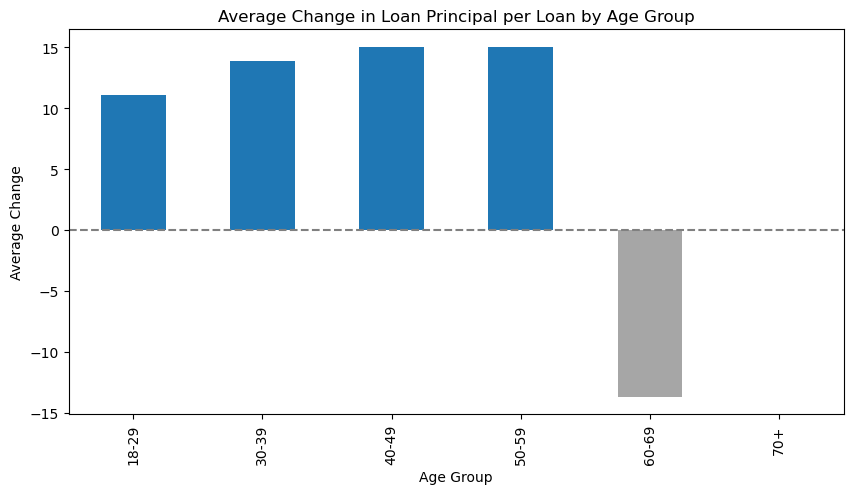

In [56]:
# Sort the average change by age group in descending order
post_sms_avg_change_age_group = post_sms_avg_change_age_group.sort_values(ascending=False)

# age groups
age_group_order = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']

# positive and negative values
plt.figure(figsize=(10, 5))
colors = ['#1f77b4' if val >= 0 else '#a6a6a6' for val in post_sms_avg_change_age_group.loc[age_group_order]]
post_sms_avg_change_age_group.loc[age_group_order].plot(kind='bar', color=colors)

plt.axhline(0, color='grey', linestyle='--')

plt.xlabel('Age Group')
plt.ylabel('Average Change')
plt.title('Average Change in Loan Principal per Loan by Age Group')
plt.show()
#trends show the ROI increased by age groups 

In [57]:
post_sms_avg_change_credit_rating_group = post_sms_avg_change_credit_rating_group.sort_values(ascending=False)

post_sms_avg_change_credit_rating_group

credit_rating_group
700-799    14.807861
500-599    13.717245
600-699    12.435788
800-899    10.803289
400-499     9.988681
dtype: float64

In [58]:
post_sms_avg_change_salary_group = post_sms_avg_change_salary_group.sort_values(ascending=False)

post_sms_avg_change_salary_group

salary_group
0-1999       13.576859
2000-3999    13.557890
4000-5999    13.331664
6000-7999          NaN
8000-9999          NaN
10000+             NaN
dtype: float64

In [59]:
post_sms_avg_change_country_sorted = post_sms_avg_change_country.sort_values(ascending=False)

# Display the sorted result
post_sms_avg_change_country_sorted


customer_country
Sweden                32.390337
Hong Kong             23.824451
Romania               22.688039
Hungary               19.285361
Philippines           17.520129
Finland               17.276923
El Salvador           17.121729
Dominican Republic    17.017821
Peru                  16.833121
Portugal              16.724072
Germany               16.688994
France                16.600090
Panama                15.565222
Estonia               15.457720
Australia             14.584848
Vietnam               14.302765
India                 14.097816
Cyprus                13.944310
Israel                13.834256
Japan                 13.745617
Switzerland           13.685419
Mexico                13.557073
Poland                12.823938
Canada                12.653129
Greece                12.555147
Brazil                12.494754
China                 12.363636
Czech Republic        11.109851
Spain                 11.040571
Bulgaria              10.603035
South Africa           

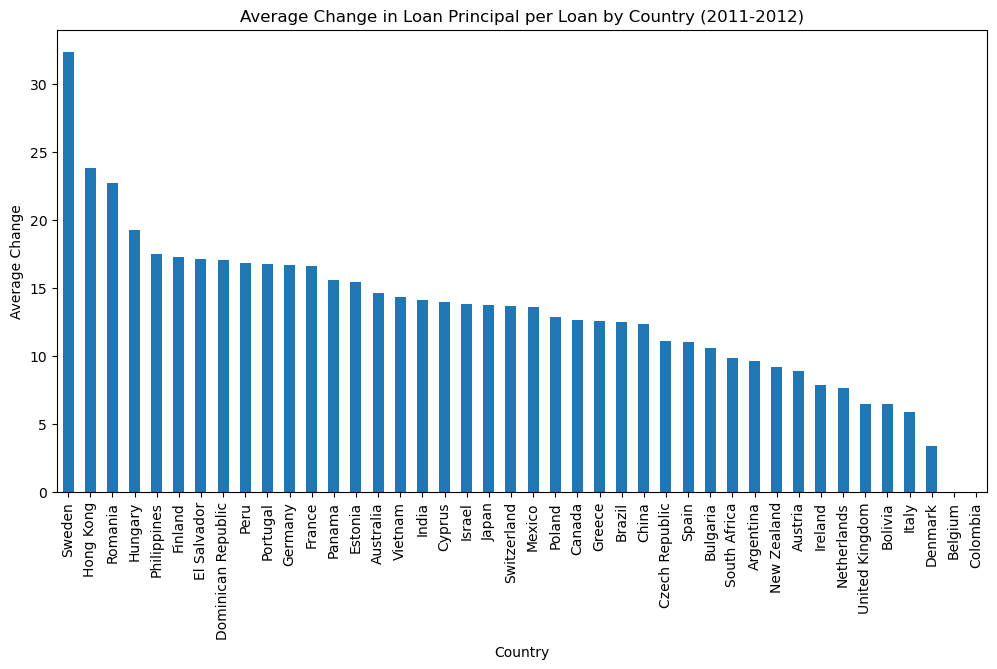

In [60]:
#import matplotlib.pyplot as plt

# Sort the average change by country in descending order
post_sms_avg_change_country_sorted = post_sms_avg_change_country.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
post_sms_avg_change_country_sorted.plot(kind='bar', color=['#1f77b4' if val >= 0 else '#a6a6a6' for val in post_sms_avg_change_country_sorted])

plt.xlabel('Country')
plt.ylabel('Average Change')
plt.title('Average Change in Loan Principal per Loan by Country (2011-2012)')
plt.show()

In [61]:
# Calculate the average loan principal per loan for each month
roi_by_month_df = df_merged_with_id.groupby('loan_month').apply(calculate_roi).apply(pd.Series)
pre_sms_avg_principal_per_loan_month = roi_by_month_df[0] / roi_by_month_df[2]
post_sms_avg_principal_per_loan_month = roi_by_month_df[1] / roi_by_month_df[3]

# Calculate the percentage increase or decrease in average loan principal per loan for each month
pre_sms_avg_change_month = (post_sms_avg_principal_per_loan_month - pre_sms_avg_principal_per_loan_month) / pre_sms_avg_principal_per_loan_month * 100
post_sms_avg_change_month = (post_sms_avg_principal_per_loan_month - pre_sms_avg_principal_per_loan_month) / pre_sms_avg_principal_per_loan_month * 100

# Calculate the average loan principal per loan for each quarter
roi_by_quarter_df = df_merged_with_id.groupby('loan_quarter').apply(calculate_roi).apply(pd.Series)
pre_sms_avg_principal_per_loan_quarter = roi_by_quarter_df[0] / roi_by_quarter_df[2]
post_sms_avg_principal_per_loan_quarter = roi_by_quarter_df[1] / roi_by_quarter_df[3]

# Calculate the percentage increase or decrease in average loan principal per loan for each quarter
pre_sms_avg_change_quarter = (post_sms_avg_principal_per_loan_quarter - pre_sms_avg_principal_per_loan_quarter) / pre_sms_avg_principal_per_loan_quarter * 100
post_sms_avg_change_quarter = (post_sms_avg_principal_per_loan_quarter - pre_sms_avg_principal_per_loan_quarter) / pre_sms_avg_principal_per_loan_quarter * 100

# Display the results
pre_sms_avg_principal_per_loan_month, post_sms_avg_principal_per_loan_month, pre_sms_avg_change_month, post_sms_avg_change_month, \
pre_sms_avg_principal_per_loan_quarter, post_sms_avg_principal_per_loan_quarter, pre_sms_avg_change_quarter, post_sms_avg_change_quarter


(loan_month
 1.0     205.130724
 2.0     208.233732
 3.0     209.218116
 4.0     212.838570
 5.0     210.161663
 6.0     210.137729
 7.0     209.892982
 8.0     206.228487
 9.0     204.822981
 10.0    202.541775
 11.0    201.421931
 12.0    200.000000
 dtype: float64,
 loan_month
 1.0     200.000000
 2.0     240.000000
 3.0     218.939394
 4.0     222.982456
 5.0     214.978903
 6.0     215.749656
 7.0     216.513761
 8.0     222.064057
 9.0     232.873637
 10.0    240.493528
 11.0    242.225564
 12.0    240.913829
 dtype: float64,
 loan_month
 1.0     -2.501197
 2.0     15.255102
 3.0      4.646480
 4.0      4.766000
 5.0      2.292159
 6.0      2.670595
 7.0      3.154360
 8.0      7.678653
 9.0     13.695073
 10.0    18.737741
 11.0    20.257791
 12.0    20.456915
 dtype: float64,
 loan_month
 1.0     -2.501197
 2.0     15.255102
 3.0      4.646480
 4.0      4.766000
 5.0      2.292159
 6.0      2.670595
 7.0      3.154360
 8.0      7.678653
 9.0     13.695073
 10.0    18.737741
 11

In [62]:
post_sms_avg_change_month = post_sms_avg_change_month.sort_values(ascending=False)

post_sms_avg_change_month

loan_month
12.0    20.456915
11.0    20.257791
10.0    18.737741
2.0     15.255102
9.0     13.695073
8.0      7.678653
4.0      4.766000
3.0      4.646480
7.0      3.154360
6.0      2.670595
5.0      2.292159
1.0     -2.501197
dtype: float64

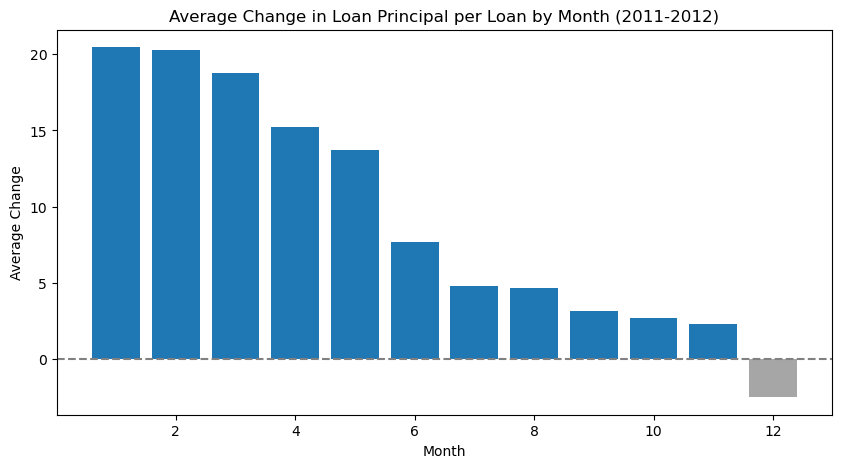

In [63]:
#import matplotlib.pyplot as plt

# Sort the average change by month in descending order
post_sms_avg_change_month = post_sms_avg_change_month.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, 13), post_sms_avg_change_month.values, color=['#1f77b4' if val >= 0 else '#a6a6a6' for val in post_sms_avg_change_month.values])

plt.axhline(0, color='grey', linestyle='--')

plt.xlabel('Month')
plt.ylabel('Average Change')
plt.title('Average Change in Loan Principal per Loan by Month (2011-2012)')

plt.show()


In [64]:
post_sms_avg_change_quarter = post_sms_avg_change_quarter.sort_values(ascending=False)

post_sms_avg_change_quarter

loan_quarter
2012Q4    9.253051
2012Q3    5.111223
2012Q1    4.409319
2012Q2    0.007274
2011Q1         NaN
2011Q2         NaN
2011Q3         NaN
2011Q4         NaN
Freq: Q-DEC, dtype: float64

5. I will evaluate the success of the campaign by looking at the loans and total loan principal for these customers before and after the SMS campaign

I can see that after the SMS campaign, the average loan principal per loan went up by 13.59%
- The total loan principal before the SMS campaigns was approximately £12,092,350
- The total loan principal after the SMS campaigns was approximately £3,212,650
- The number of loans before the SMS campaigns was 58,576
- The number of loans after the SMS campaigns was 13,703.
- Average loan principal per loan before SMS campaign: £206
- Average loan principal per loan before SMS campaign: £234
- That's an increase of 13.59%
- The cost of the SMS campaigns was approximately £5,313.

But I wanted to understand what was happening further. I decided to break it down by the following criteria:

1. ROI by Country
2. ROI by Age Group
3. ROI by Credit Rating Group
4. ROI by Salary Group

In [65]:
# Create a column indicating whether the customer received an SMS
df_merged_with_id['received_sms'] = df_merged_with_id['sms_id'].notna()

# Filter the data to only include customers who received an SMS and had more than one loan
df_repeat_customers = df_merged_with_id.loc[df_merged_with_id['received_sms'] & (df_merged_with_id["customer's_nth_loan"] > 1)]

# Calculate the total loan principal and the number of loans for these customers
total_principal_repeat_customers = df_repeat_customers['loan_principal'].sum()
num_loans_repeat_customers = df_repeat_customers['loan_principal'].count()

# Calculate the ROI for these customers
roi_repeat_customers = (total_principal_repeat_customers - num_loans_repeat_customers * 0.10) / (num_loans_repeat_customers * 0.10)

# Display the results
total_principal_repeat_customers, num_loans_repeat_customers, roi_repeat_customers

print("Total Loan Principal for Repeat Customers: £", total_principal_repeat_customers)
print("Number of Loans for Repeat Customers:", num_loans_repeat_customers)
print("ROI for Repeat Customers: £", roi_repeat_customers)


Total Loan Principal for Repeat Customers: £ 5558950
Number of Loans for Repeat Customers: 23635
ROI for Repeat Customers: £ 2350.9991537973347


#### ROI by Country:
- The ROI was positive across all countries, as loan principal increased significantly
- The ROI increased the most for Sweden, where loan principal increased by 32%


#### ROI by Age Group:
- The ROI is positive for all age groups, with 40-49 responding the best to the SMS campaigns. Increasing by 15%
- 60-69 year olds responded the worst, with a significant drop in loan principal amount.


#### ROI by Credit Rating Group:
- Customers in the 700-799 credit rating group responded the best with a 14% increase in loan principal
- Customers in the lowest credit rating group responded the worst only increasing by 9.9%

#### ROI by Salary Group:
- Customers in all salary groups responded about the same as I do not see a significant difference in the increase in loan principal when comparing the groups. All increased by about 13%.

Based on the above, I can see that the SMS campaign was most successful in Sweden and for customers ages 40-49. Although other age groups such as 50-59 also increased significantly too.

The final data analytsis I wanted to run on it was to find out how the SMS campaign promoted customer loyalty, and by month.

#### ROI by Month:
- I can see that the biggest increase for the month of December, followed by November and October. This may be because of holidays rather than the SMS campaign though.  

#### Impact on customer loyalty:
- Total loan principal for customers who received an SMS and had more than one loan is £5,558,950. 
- The number of loans for these customers is 23,635. 
- The ROI for these customers, calculated as (total loan principal - number of loans * cost per SMS) / (number of loans * cost per SMS), is £2350.

This suggests the SMS campaigns were hgighly successful for custgomers who had more than one loan, as they led to a significant increase in loan principal and a high ROI. This indicates that the SMS campaigns were effective in promoting loyalty and repeat business.

### Assumption impact
- By assuming that SMS with no sms_cust_id were tests, I potentially increased the ROI per sent SMS.
- By removing customers with large salaries, this may have impacted the results of the analysis by salary group

### Results
- When I look at ROI by Month, Salary, Credit Rating, Age and Country I can see a positive ROI when I look at the amount borrowed after the SMS campaign
- Among these, Sweden and customers between the ages of 40-59 had the most positive ROI
- The positive takeaway, and the metric that contributes most to the success of this campaign is customer loyalty. The SMS campaign had a great ROI when I look at customers who had more than 1 loan.
- The total loan prinicpal for customers who received an SMS and more than one loan is £5,558,950
- The number of loans these customers had is 23,635.
- The ROI for these customers is £2350.

This is good because as I have seen, repeat customers are the safest and tend to default less on their loans, they are also the most profitable. 

# Conclusion

- I have enough data to make an informed decision on how to mitigate bad debt
- I have enough data to suggest a strategy to QuidCo that would help maximise profit while being cautious
- By sending SMS campaigns QuidCo and LoanCorp can promote customer loyalty and repeat business, and in general increase the amount borrowed by customers.
- Repeat customers offer the least risk and highest return.
- Repeat customers are also approved more quickly, and this leads to an improvement in ID verification time
- Country, Age, Salary, Credit Rating also make a significant impact to how risky a loan is, and stricter criteria can be applied to customers from high risk groups
- This will impact the return the company can make, but as long as they focus on the top 50% of profitable loans and target repeat business and customers with larger principals, businesses stand to make a large return.
